# Stratified y-values testing

Apply procedure from Brusco, M. J.; Cradit, J. D.; Steinley, D.; Fox, G. L. Cautionary Remarks on the Use of Clusterwise Regression. Multivar. Behav. Res. 2008, 43 (1), 29–49.

to determine if within cluster regression models are aiding in predictive power above the benefit from simple clustering 

## Imports and data cleanup

In [1]:
import sys

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from prepare_dataset import prepare_dataset
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
plt.rcParams.update(plt.rcParamsDefault)

sys.path.append('../src')
import rccr

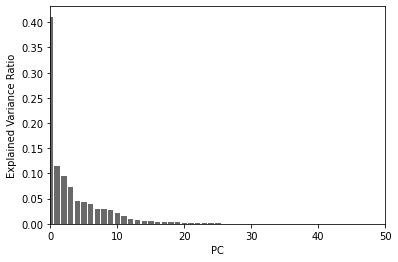

In [2]:
df = prepare_dataset('../data/Palladium_Database.xlsx')

df_train, df_test = train_test_split(df,test_size=0.1, random_state=25)

X_train = df_train.iloc[:,6:]
X_test = df_test.iloc[:,6:]
y_train = df_train['DDG']
y_test = df_test['DDG']

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA().fit(X_train_scaled)
pcs = pca.transform(X_train_scaled)[:,:20]
pcs_test = pca.transform(X_test_scaled)[:,:20]

plt.bar(range(0,len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_, color='dimgrey')
plt.xlabel('PC')
plt.ylabel('Explained Variance Ratio')
plt.xlim(0,50)
plt.show()

## Apply RCCR to find labels

In [3]:
new_labels = rccr.get_average_clusters(pcs,y_train.values,n_clusters=6,iterations=80,max_iteration_cluster=5, plot=False)

Initial r2 0.35198922900505
Initial r2 0.35198922900505
Initial r2 0.35198922900505
Initial r2 0.35198922900505
Initial r2 0.35198922900505
Initial r2 0.35198922900505
Initial r2 0.35198922900505
Initial r2 0.35198922900505
Initial r2 0.35198922900505
Initial r2 0.35198922900505
Initial r2 0.35198922900505
Initial r2 0.35198922900505
Iteration 0 0.8046208795086827
Iteration 0 0.8277255830388706
Iteration 0 0.8034601576975113
Iteration 0 0.8267154301424889
Iteration 0 0.821303096067672
Iteration 0 0.8237911358854331
Iteration 0 0.8266318566071726
Iteration 0 0.8032233725060802
Iteration 0 0.8071453152628124
Iteration 0 0.8223710988765315
Iteration 0 0.8165664776846918
Iteration 0 0.8045029613448973
Iteration 1 0.8630393136339248
Iteration 1 0.8858342834699316
Iteration 1 0.867833797759066
Iteration 1 0.86196138942927
Iteration 1 0.8755354796778502
Iteration 1 0.8777628168132661
Iteration 1 0.8725994907548715
Iteration 1 0.8636347314420666
Iteration 1 0.8738874836600455
Iteration 1 0.866

In [4]:
model = RandomForestClassifier().fit(X_train_scaled,new_labels)
test_labels = model.predict(X_test_scaled)

concat_meas, concat_pred, concat_labels, concat_test_meas, concat_test_pred, concat_test_labels = rccr.cr_fit_predict(pcs,y_train.values,new_labels, pcs_test,y_test.values,test_labels)
print("cr R2 " + str(r2_score(concat_meas, concat_pred)))
print("cr MAE  " + str(mean_absolute_error(concat_meas, concat_pred)))

print("test R2 " + str(r2_score(concat_test_meas, concat_test_pred)))
print("test MAE  " + str(mean_absolute_error(concat_test_meas, concat_test_pred)))

original_r2_train = r2_score(concat_meas, concat_pred)
original_mae_train = mean_absolute_error(concat_meas, concat_pred)

original_r2_test = r2_score(concat_test_meas, concat_test_pred)
original_mae_test = mean_absolute_error(concat_test_meas, concat_test_pred)

Cluster 0 R2 0.89944284603439 coeff [0.47892342244777664][4] int 1.852978215139356
Cluster 1 R2 0.9330823817077342 coeff [0.4634154030271926][4] int 1.3196024846107215
Cluster 2 R2 0.8673026630030809 coeff [0.553038357416193][2] int 3.0833619857132724
Cluster 3 R2 0.883352217567864 coeff [0.3167211275614123][9] int 1.672074741000609
Cluster 4 R2 0.8216882259841183 coeff [0.6477940498852048][10] int 1.1229441840446186
Cluster 5 R2 0.9012428220214499 coeff [0.9540315389290372][13] int 1.3791262296608446
cr R2 0.8768566554327625
cr MAE  0.15594216966448768
test R2 0.5162888961044845
test MAE  0.30188119895401727


## Randomly shuffle y values and run analysis 100 times

Note: this section will take quite long to run, ~ 24 hours with the default parameter settings on a local 12-core PC

In [6]:
from tqdm import tqdm

meas_r2 = []
test_r2 = []
meas_mae = []
test_mae = []


for i in tqdm(range(0,100)):
    y_random = y_train.values
    y_random_test = y_test.values
    np.random.shuffle(y_random)
    np.random.shuffle(y_random_test)
    new_labels = rccr.get_average_clusters(pcs,y_train.values,n_clusters=6,iterations=80,max_iteration_cluster=5, plot=False)
    model = RandomForestClassifier().fit(X_train_scaled,new_labels)
    test_labels = model.predict(X_test_scaled)

    concat_meas, concat_pred, concat_labels, concat_test_meas, concat_test_pred, concat_test_labels = rccr.cr_fit_predict(pcs,y_random,new_labels, pcs_test,y_random_test,test_labels)
    meas_r2.append(r2_score(concat_meas,concat_pred))
    test_r2.append(r2_score(concat_test_meas,concat_test_pred))
    meas_mae.append(mean_absolute_error(concat_meas,concat_pred))
    test_mae.append(mean_absolute_error(concat_test_meas,concat_test_pred))

  0%|          | 0/100 [00:00<?, ?it/s]

Initial r2 0.20625200991165168
Initial r2 0.20625200991165168
Initial r2 0.20625200991165168
Initial r2 0.20625200991165168
Initial r2 0.20625200991165168
Initial r2 0.20625200991165168
Initial r2 0.20625200991165168
Initial r2 0.20625200991165168
Initial r2 0.20625200991165168
Initial r2 0.20625200991165168
Initial r2 0.20625200991165168
Initial r2 0.20625200991165168
Iteration 0 0.7429822511914952
Iteration 0 0.6392130964612507
Iteration 0 0.6759174682993508
Iteration 0 0.680540436162596
Iteration 0 0.6750035310944905
Iteration 0 0.6688523252609074
Iteration 0 0.7064253660234212
Iteration 0 0.7069774761214491
Iteration 0 0.6370793722373889
Iteration 0 0.6863902570334304
Iteration 0 0.6816094681160908
Iteration 0 0.7120191229658824
Iteration 1 0.7968419667161029
Iteration 1 0.8278793048817735
Iteration 1 0.7306879602027988
Iteration 1 0.7521272685856145
Iteration 1 0.7387804860916883
Iteration 1 0.7606388574726547
Iteration 1 0.7872818307529313
Iteration 1 0.8074632111873489
Iteration

  1%|          | 1/100 [16:43<27:35:17, 1003.21s/it]

Cluster 0 R2 0.9695795924389827 coeff [0.13450175988650528][0] int 0.854357985541824
Cluster 1 R2 0.8287936143033412 coeff [0.3790043790579363][8] int 1.7442304319332105
Cluster 2 R2 0.808770614478371 coeff [0.7133867360557645][10] int 2.271719132813155
Cluster 3 R2 0.8699857339765331 coeff [0.5602697518520204][3] int 0.8466843297734328
Cluster 4 R2 0.5638767802393984 coeff [0.42426727104880224][7] int 1.622282274808816
Cluster 5 R2 0.6706131794167737 coeff [0.18551280378812346][1] int 1.239112932317205
Initial r2 0.20357883833435356
Initial r2 0.20357883833435356
Initial r2 0.20357883833435356
Initial r2 0.20357883833435356
Initial r2 0.20357883833435356
Initial r2 0.20357883833435356
Initial r2 0.20357883833435356
Initial r2 0.20357883833435356
Initial r2 0.20357883833435356
Initial r2 0.20357883833435356
Initial r2 0.20357883833435356
Initial r2 0.20357883833435356
Iteration 0 0.7335466371348359
Iteration 0 0.6673599944601434
Iteration 0 0.7263154553920933
Iteration 0 0.728562541988

  2%|▏         | 2/100 [33:16<27:09:07, 997.42s/it] 

Cluster 0 R2 0.3130752606230581 coeff [0.22561541897491016][4] int 1.3471647513405716
Cluster 1 R2 0.9494607991215227 coeff [0.1502517308047915][0] int 0.9174201425105726
Cluster 2 R2 0.862424676781182 coeff [0.12632637645689124][0] int 2.147494664937066
Cluster 3 R2 0.8999440066755614 coeff [1.1710629351880701][19] int 1.3524944750091659
Cluster 4 R2 0.6869068097556934 coeff [0.15613207626579548][2] int 1.3122213245745085
Cluster 5 R2 0.9438031968592576 coeff [1.5308509290716668][15] int 2.0459887156843544
Initial r2 0.2296957574792947
Initial r2 0.2296957574792947
Initial r2 0.2296957574792947
Initial r2 0.2296957574792947
Initial r2 0.2296957574792947
Initial r2 0.2296957574792947
Initial r2 0.2296957574792947
Initial r2 0.2296957574792947
Initial r2 0.2296957574792947
Initial r2 0.2296957574792947
Initial r2 0.2296957574792947
Initial r2 0.2296957574792947
Iteration 0 0.7722945317755557
Iteration 0 0.7191944382885906
Iteration 0 0.7543571118188371
Iteration 0 0.7046202772580674
Ite

  3%|▎         | 3/100 [49:46<26:47:04, 994.07s/it]

Cluster 0 R2 0.575271807894296 coeff [0.11266535693183705][0] int 0.6811323298020555
Cluster 1 R2 0.9122956134216751 coeff [3.119089561722719][16] int 1.8775209825874013
Cluster 2 R2 0.3492209888068316 coeff [0.5193607204614155][13] int 1.7486104427451645
Cluster 3 R2 0.8627116514234728 coeff [0.4120476794176673][7] int 1.5082402573444924
Cluster 4 R2 0.8975959671254783 coeff [0.39616711282305633][2] int 2.1720250373737255
Cluster 5 R2 0.9112017237488935 coeff [0.6711727100967171][6] int 1.7920855967728828
Initial r2 0.23182171084680772
Initial r2 0.23182171084680772
Initial r2 0.23182171084680772
Initial r2 0.23182171084680772
Initial r2 0.23182171084680772
Initial r2 0.23182171084680772
Initial r2 0.23182171084680772
Initial r2 0.23182171084680772
Initial r2 0.23182171084680772
Initial r2 0.23182171084680772
Initial r2 0.23182171084680772
Initial r2 0.23182171084680772
Iteration 0 0.7306665117680371
Iteration 0 0.7297795232208203
Iteration 0 0.7002231229663985
Iteration 0 0.722341859

  4%|▍         | 4/100 [1:06:23<26:32:19, 995.20s/it]

Cluster 0 R2 0.7666312331424385 coeff [0.309046227816558][2] int 2.0235391717531983
Cluster 1 R2 0.8370063757145813 coeff [0.5187970036532425][4] int 2.005315419150765
Cluster 2 R2 0.975772609331122 coeff [0.47640339854316205][4] int 1.0750636463762808
Cluster 3 R2 0.6120595778443849 coeff [1.052640093841297][15] int 1.439957630227852
Cluster 4 R2 0.8215512246789415 coeff [0.5158421566394145][12] int 1.1589162081303725
Cluster 5 R2 0.8879396649484476 coeff [0.27553836448430025][1] int 0.7463536202743379
Initial r2 0.21383895723806123
Initial r2 0.21383895723806123
Initial r2 0.21383895723806123
Initial r2 0.21383895723806123
Initial r2 0.21383895723806123
Initial r2 0.21383895723806123
Initial r2 0.21383895723806123
Initial r2 0.21383895723806123
Initial r2 0.21383895723806123
Initial r2 0.21383895723806123
Initial r2 0.21383895723806123
Initial r2 0.21383895723806123
Iteration 0 0.6965427796400383
Iteration 0 0.6962213397943481
Iteration 0 0.7284048407176656
Iteration 0 0.750456692784

  5%|▌         | 5/100 [1:22:54<26:13:00, 993.47s/it]

Cluster 0 R2 0.9052101886836385 coeff [0.47575897813861034][4] int 0.7928731052829782
Cluster 1 R2 0.9104408564279131 coeff [0.3417423287440339][3] int 1.6004386145172502
Cluster 2 R2 0.9285451308031046 coeff [0.42354459671492284][2] int 2.1371897016668804
Cluster 3 R2 0.8679522750920265 coeff [0.5452784172796249][5] int 1.5128165853345925
Cluster 4 R2 0.7556600011974336 coeff [0.3961745949195688][7] int 1.4376660441831532
Cluster 5 R2 0.6190658682018514 coeff [0.561124855411966][4] int 2.0705959460707346
Initial r2 0.19128443511529192
Initial r2 0.19128443511529192
Initial r2 0.19128443511529192
Initial r2 0.19128443511529192
Initial r2 0.19128443511529192
Initial r2 0.19128443511529192
Initial r2 0.19128443511529192
Initial r2 0.19128443511529192
Initial r2 0.19128443511529192
Initial r2 0.19128443511529192
Initial r2 0.19128443511529192
Initial r2 0.19128443511529192
Iteration 0 0.6918909991169043
Iteration 0 0.7827543199822214
Iteration 0 0.6979221905521751
Iteration 0 0.7669532826

  6%|▌         | 6/100 [1:39:30<25:57:49, 994.36s/it]

Cluster 0 R2 0.7678518448173659 coeff [0.4329894749064641][5] int 1.810997028615097
Cluster 1 R2 0.7459315129342065 coeff [0.3263271681192986][3] int 1.331964581931671
Cluster 2 R2 0.9644003797565339 coeff [0.1571369637721893][0] int 0.8448273867520293
Cluster 3 R2 0.8154819882590065 coeff [1.4366537684151115][19] int 1.8030533242828535
Cluster 4 R2 0.9284101363631361 coeff [0.3456894732385754][2] int 1.0510939734265254
Cluster 5 R2 0.5013152997191938 coeff [0.2652227849880315][8] int 1.5010304227804518
Initial r2 0.23040426886202567
Initial r2 0.23040426886202567
Initial r2 0.23040426886202567
Initial r2 0.23040426886202567
Initial r2 0.23040426886202567
Initial r2 0.23040426886202567
Initial r2 0.23040426886202567
Initial r2 0.23040426886202567
Initial r2 0.23040426886202567
Initial r2 0.23040426886202567
Initial r2 0.23040426886202567
Initial r2 0.23040426886202567
Iteration 0 0.720332606682959
Iteration 0 0.7144533824739746
Iteration 0 0.705423824448571
Iteration 0 0.70958517529537

  7%|▋         | 7/100 [1:55:59<25:38:50, 992.80s/it]

Cluster 0 R2 0.7889845186898843 coeff [0.6550241148003015][3] int 0.6704443418964267
Cluster 1 R2 0.8933150983001774 coeff [4.421657811708563][16] int 1.7540600823434127
Cluster 2 R2 0.8799134063841637 coeff [0.8516500967291248][12] int 1.6206313412358053
Cluster 3 R2 0.8442402572834439 coeff [0.33330248473513446][2] int 2.2740950432012905
Cluster 4 R2 0.8122142729439298 coeff [0.276081642136017][2] int 1.1180558297709173
Cluster 5 R2 0.30036930493527825 coeff [0.07155817532964372][0] int 1.6797437065217078
Initial r2 0.23397979626274776
Initial r2 0.23397979626274776
Initial r2 0.23397979626274776
Initial r2 0.23397979626274776
Initial r2 0.23397979626274776
Initial r2 0.23397979626274776
Initial r2 0.23397979626274776
Initial r2 0.23397979626274776
Initial r2 0.23397979626274776
Initial r2 0.23397979626274776
Initial r2 0.23397979626274776
Initial r2 0.23397979626274776
Iteration 0 0.7045191924088718
Iteration 0 0.7171580788123761
Iteration 0 0.7596622732385064
Iteration 0 0.73502127

  8%|▊         | 8/100 [2:12:36<25:24:27, 994.22s/it]

Cluster 0 R2 0.7167872450484684 coeff [0.23758697678697566][1] int 1.9559437743354215
Cluster 1 R2 0.7101117383581398 coeff [1.8208533020798476][18] int 1.5503201289530035
Cluster 2 R2 0.9202957201308427 coeff [0.13994212431506448][0] int 2.0990162072935026
Cluster 3 R2 0.8661124533413764 coeff [1.1752123894409678][14] int 1.2162925312354165
Cluster 4 R2 0.7228172774517607 coeff [1.1019017647846017][15] int 1.3291502252147067
Cluster 5 R2 0.8494674701746543 coeff [0.4968858176496025][6] int 1.3571978818362187
Initial r2 0.1954604690654506
Initial r2 0.1954604690654506
Initial r2 0.1954604690654506
Initial r2 0.1954604690654506
Initial r2 0.1954604690654506
Initial r2 0.1954604690654506
Initial r2 0.1954604690654506
Initial r2 0.1954604690654506
Initial r2 0.1954604690654506
Initial r2 0.1954604690654506
Initial r2 0.1954604690654506
Initial r2 0.1954604690654506
Iteration 0 0.7143870139056894
Iteration 0 0.764085737929585
Iteration 0 0.7508116267524821
Iteration 0 0.7775409560648502
It

  9%|▉         | 9/100 [2:30:12<25:36:53, 1013.34s/it]

Cluster 0 R2 0.8790337270664539 coeff [0.4304177499060774][10] int 1.7431504762491226
Cluster 1 R2 0.6454086256026634 coeff [0.4338693319263808][3] int 1.3764737034242112
Cluster 2 R2 0.797825970690816 coeff [0.2826880036068819][1] int 1.7995959011058318
Cluster 3 R2 0.5334301629776308 coeff [0.04890078619523872][1] int 1.695894655989796
Cluster 4 R2 0.9226118357428051 coeff [0.15282826229750307][0] int 1.9634663789879876
Cluster 5 R2 0.8163297780331165 coeff [0.4119444055640014][2] int 1.1584978684762859
Initial r2 0.22443512403097596
Initial r2 0.22443512403097596
Initial r2 0.22443512403097596
Initial r2 0.22443512403097596
Initial r2 0.22443512403097596
Initial r2 0.22443512403097596
Initial r2 0.22443512403097596
Initial r2 0.22443512403097596
Initial r2 0.22443512403097596
Initial r2 0.22443512403097596
Initial r2 0.22443512403097596
Initial r2 0.22443512403097596
Iteration 0 0.6818737214402685
Iteration 0 0.6528817142691904
Iteration 0 0.6964895545033554
Iteration 0 0.7187493878

 10%|█         | 10/100 [2:48:14<25:51:47, 1034.53s/it]

Cluster 0 R2 0.7102838834183731 coeff [0.8634588781796689][18] int 1.4579725949312592
Cluster 1 R2 0.8873518003715548 coeff [0.8395530157847733][15] int 1.7119895098225741
Cluster 2 R2 0.4793101273242628 coeff [0.3266995583093736][12] int 1.5681253738629481
Cluster 3 R2 0.3669190607296019 coeff [0.5534238777163213][12] int 2.1123557147625283
Cluster 4 R2 0.8206537679358303 coeff [0.5292005665384896][2] int 1.3988314844298695
Cluster 5 R2 0.7692857537088288 coeff [0.8005871746095323][13] int 1.3024573058877622
Initial r2 0.21195717917086063
Initial r2 0.21195717917086063
Initial r2 0.21195717917086063
Initial r2 0.21195717917086063
Initial r2 0.21195717917086063
Initial r2 0.21195717917086063
Initial r2 0.21195717917086063
Initial r2 0.21195717917086063
Initial r2 0.21195717917086063
Initial r2 0.21195717917086063
Initial r2 0.21195717917086063
Initial r2 0.21195717917086063
Iteration 0 0.6457101475680572
Iteration 0 0.6708122592203835
Iteration 0 0.6621203453619146
Iteration 0 0.682648

 11%|█         | 11/100 [3:06:08<25:52:24, 1046.56s/it]

Cluster 0 R2 0.521257754824449 coeff [0.6208222311870839][4] int 1.3434391669996903
Cluster 1 R2 0.39186823505935797 coeff [0.08405523069941649][0] int 1.958691179449844
Cluster 2 R2 0.7981278547322278 coeff [0.860695659813361][13] int 1.249895153668853
Cluster 3 R2 0.7766142776972098 coeff [0.364981986561633][3] int 2.0547072321040076
Cluster 4 R2 0.9215456259069772 coeff [0.414739129708057][7] int 1.4261647501073969
Cluster 5 R2 0.8329197844761509 coeff [0.7312502578519393][12] int 1.7155114428818885
Initial r2 0.1919705953250733
Initial r2 0.1919705953250733
Initial r2 0.1919705953250733
Initial r2 0.1919705953250733
Initial r2 0.1919705953250733
Initial r2 0.1919705953250733
Initial r2 0.1919705953250733
Initial r2 0.1919705953250733
Initial r2 0.1919705953250733
Initial r2 0.1919705953250733
Initial r2 0.1919705953250733
Initial r2 0.1919705953250733
Iteration 0 0.710846872447811
Iteration 0 0.6353665480896898
Iteration 0 0.7276158472323703
Iteration 0 0.7157233158102665
Iteration

 12%|█▏        | 12/100 [3:24:01<25:46:59, 1054.77s/it]

Cluster 0 R2 0.3377931068156681 coeff [0.4608877159006126][12] int 1.5255230587230817
Cluster 1 R2 0.9500873777010139 coeff [0.43816038044889916][7] int 1.4950172559568904
Cluster 2 R2 0.6298037371038163 coeff [0.38720417559989306][3] int 1.6014168682007264
Cluster 3 R2 0.7600908963346314 coeff [0.5305596850550874][2] int 1.3020634251397065
Cluster 4 R2 0.9352441258504435 coeff [0.30310285825012934][8] int 1.395505412731063
Cluster 5 R2 0.9165599481578133 coeff [0.14791838440088806][0] int 2.279913321749133
Initial r2 0.19663974365676218
Initial r2 0.19663974365676218
Initial r2 0.19663974365676218
Initial r2 0.19663974365676218
Initial r2 0.19663974365676218
Initial r2 0.19663974365676218
Initial r2 0.19663974365676218
Initial r2 0.19663974365676218
Initial r2 0.19663974365676218
Initial r2 0.19663974365676218
Initial r2 0.19663974365676218
Initial r2 0.19663974365676218
Iteration 0 0.7125818293049578
Iteration 0 0.7499858249614381
Iteration 0 0.7635061204859174
Iteration 0 0.73770409

 13%|█▎        | 13/100 [3:41:54<25:37:22, 1060.26s/it]

Cluster 0 R2 0.841687014333792 coeff [0.13863401868816447][0] int 2.1146425839532372
Cluster 1 R2 0.5565883696262008 coeff [0.3541841804541481][3] int 1.6332135250440571
Cluster 2 R2 0.5939350599713569 coeff [0.8060091626305367][12] int 1.167941109429884
Cluster 3 R2 0.8778448695880643 coeff [0.39530840150287294][6] int 1.4358105735726259
Cluster 4 R2 0.23247487897982144 coeff [0.1634202496914093][2] int 1.4341408062799785
Cluster 5 R2 0.9325938546163725 coeff [0.3421200408529166][2] int 1.9947798305602895
Initial r2 0.2309258645835303
Initial r2 0.2309258645835303
Initial r2 0.2309258645835303
Initial r2 0.2309258645835303
Initial r2 0.2309258645835303Initial r2 0.2309258645835303

Initial r2 0.2309258645835303
Initial r2 0.2309258645835303
Initial r2 0.2309258645835303
Initial r2 0.2309258645835303
Initial r2 0.2309258645835303
Initial r2 0.2309258645835303
Iteration 0 0.7204803312206559
Iteration 0 0.6811413335670484
Iteration 0 0.7188591726919985
Iteration 0 0.7001843087467302
Iter

 14%|█▍        | 14/100 [3:59:42<25:22:57, 1062.53s/it]

Cluster 0 R2 0.97068562900154 coeff [0.12738251486680213][0] int 0.9302498273834614
Cluster 1 R2 0.7442507620824079 coeff [2.2166319189768475][18] int 1.6141379823730344
Cluster 2 R2 0.8757883838029867 coeff [0.42654236423254743][9] int 1.405777368076677
Cluster 3 R2 0.9747749728086347 coeff [1.691904862501994][0] int 10.288701955783194
Cluster 4 R2 0.771920891046858 coeff [0.4313567980581807][7] int 1.7446017722594764
Cluster 5 R2 0.5167752769919718 coeff [0.22819992559245894][6] int 1.5362157107135321
Initial r2 0.19460712058054588
Initial r2 0.19460712058054588
Initial r2 0.19460712058054588
Initial r2 0.19460712058054588
Initial r2 0.19460712058054588
Initial r2 0.19460712058054588
Initial r2 0.19460712058054588
Initial r2 0.19460712058054588
Initial r2 0.19460712058054588
Initial r2 0.19460712058054588
Initial r2 0.19460712058054588
Initial r2 0.19460712058054588
Iteration 0 0.7176142636577539
Iteration 0 0.6884728980806316
Iteration 0 0.6978134191167168
Iteration 0 0.741258016023

 15%|█▌        | 15/100 [4:17:40<25:11:49, 1067.18s/it]

Cluster 0 R2 0.7499590077193279 coeff [0.37660394139379344][5] int 1.3739464643555888
Cluster 1 R2 0.9361941133986559 coeff [0.14238121127707692][0] int 2.0862166074583417
Cluster 2 R2 0.9392726236165356 coeff [0.13096174308857372][0] int 0.837599821910335
Cluster 3 R2 0.9049992092069146 coeff [1.3690992919449252][18] int 1.5508306827238998
Cluster 4 R2 0.9225103163516062 coeff [1.3162858937161703][13] int 1.4799317802967704
Cluster 5 R2 0.3477463354090954 coeff [0.23151133007269414][2] int 1.7039913895330743
Initial r2 0.23137129453804098
Initial r2 0.23137129453804098
Initial r2 0.23137129453804098
Initial r2 0.23137129453804098
Initial r2 0.23137129453804098
Initial r2 0.23137129453804098
Initial r2 0.23137129453804098
Initial r2 0.23137129453804098
Initial r2 0.23137129453804098
Initial r2 0.23137129453804098
Initial r2 0.23137129453804098
Initial r2 0.23137129453804098
Iteration 0 0.6641252842457986
Iteration 0 0.6921334989024186
Iteration 0 0.6896140478404145
Iteration 0 0.633356

 16%|█▌        | 16/100 [4:35:34<24:57:09, 1069.40s/it]

Cluster 0 R2 0.7123606172294308 coeff [0.5557486255179557][12] int 1.665689456491194
Cluster 1 R2 0.6308163031175035 coeff [0.2441980211083563][9] int 1.2212509250603836
Cluster 2 R2 0.8809715791755834 coeff [3.389773142633574][16] int 1.3052879860229356
Cluster 3 R2 0.8011387745836533 coeff [3.080686534394319][16] int 2.0863791424281066
Cluster 4 R2 0.49801647253676395 coeff [0.4317997307830935][8] int 1.793765944143403
Cluster 5 R2 0.905799986462514 coeff [0.12597703605376687][0] int 0.8131439381865159
Initial r2 0.25394317743669825
Initial r2 0.25394317743669825
Initial r2 0.25394317743669825
Initial r2 0.25394317743669825
Initial r2 0.25394317743669825
Initial r2 0.25394317743669825
Initial r2 0.25394317743669825
Initial r2 0.25394317743669825
Initial r2 0.25394317743669825
Initial r2 0.25394317743669825
Initial r2 0.25394317743669825
Initial r2 0.25394317743669825
Iteration 0 0.7708915416240295
Iteration 0 0.7558456407393077
Iteration 0 0.7252751974632977
Iteration 0 0.74563909753

 17%|█▋        | 17/100 [4:53:33<24:43:11, 1072.18s/it]

Cluster 0 R2 0.5019826625678894 coeff [0.161488929707466][1] int 1.9846940920107294
Cluster 1 R2 0.8226964731272328 coeff [1.637236272679213][19] int 1.7231689650278728
Cluster 2 R2 0.9280528105357846 coeff [0.14874516387291403][0] int 2.0542275554653666
Cluster 3 R2 0.8546226946694502 coeff [0.520174074959416][6] int 1.2394817134149672
Cluster 4 R2 0.933259499224877 coeff [0.3350407791010658][1] int 1.0353327887799386
Cluster 5 R2 0.6638584270722767 coeff [0.4753433690326094][10] int 1.63850302047935
Initial r2 0.27100460718823044
Initial r2 0.27100460718823044
Initial r2 0.27100460718823044
Initial r2 0.27100460718823044
Initial r2 0.27100460718823044Initial r2 0.27100460718823044

Initial r2 0.27100460718823044
Initial r2 0.27100460718823044
Initial r2 0.27100460718823044
Initial r2 0.27100460718823044
Initial r2 0.27100460718823044
Initial r2 0.27100460718823044
Iteration 0 0.7031745203974266
Iteration 0 0.7236247261823525
Iteration 0 0.6849677025654343
Iteration 0 0.74333482503360

 18%|█▊        | 18/100 [5:11:12<24:20:00, 1068.30s/it]

Cluster 0 R2 0.506492781885515 coeff [0.42408711923295694][10] int 1.9494391179827604
Cluster 1 R2 0.838570220276248 coeff [0.6035109283007497][8] int 0.8790290239974056
Cluster 2 R2 0.9706009016946402 coeff [1.078923978510795][15] int 1.6722166930158198
Cluster 3 R2 0.8909759606344678 coeff [1.019349957612021][13] int 1.3781816828669515
Cluster 4 R2 0.3796173408608875 coeff [0.2728251722112818][8] int 1.629752275187915
Cluster 5 R2 0.9517282129182775 coeff [1.2175154031391409][16] int 1.559472582067971
Initial r2 0.19426180013496186Initial r2 0.19426180013496186Initial r2 0.19426180013496186

Initial r2 0.19426180013496186

Initial r2 0.19426180013496186
Initial r2 0.19426180013496186
Initial r2 0.19426180013496186
Initial r2 0.19426180013496186
Initial r2 0.19426180013496186
Initial r2 0.19426180013496186
Initial r2 0.19426180013496186
Initial r2 0.19426180013496186
Iteration 0 0.6903871535853172
Iteration 0 0.680097388728147
Iteration 0 0.6684018070343503
Iteration 0 0.6330021858839

 19%|█▉        | 19/100 [5:29:17<24:08:41, 1073.10s/it]

Cluster 0 R2 0.9381356995569929 coeff [0.1377755894902692][0] int 2.2384226282413366
Cluster 1 R2 0.697553797908168 coeff [0.7841939474735753][13] int 1.803195875573085
Cluster 2 R2 0.8550765708292709 coeff [0.5269422831723604][6] int 1.7834411034210016
Cluster 3 R2 0.673401643893789 coeff [0.6232789539858641][3] int 2.1843056808388814
Cluster 4 R2 0.737935503378365 coeff [0.9598399354537351][13] int 1.1169206595550376
Cluster 5 R2 0.7928894389325684 coeff [0.39238227439956547][2] int 1.8109982782215377
Initial r2 0.19645799825036736Initial r2 0.19645799825036736
Initial r2 0.19645799825036736
Initial r2 0.19645799825036736
Initial r2 0.19645799825036736

Initial r2 0.19645799825036736
Initial r2 0.19645799825036736
Initial r2 0.19645799825036736
Initial r2 0.19645799825036736
Initial r2 0.19645799825036736
Initial r2 0.19645799825036736
Initial r2 0.19645799825036736
Iteration 0 0.6932305653694302
Iteration 0 0.727370712406706
Iteration 0 0.722913748303282
Iteration 0 0.68159566758899

 20%|██        | 20/100 [5:47:12<23:51:55, 1073.94s/it]

Cluster 0 R2 0.9418428257372551 coeff [0.24296025435524138][6] int 1.5146224622645088
Cluster 1 R2 0.7062779836270361 coeff [0.45000892378867585][7] int 2.1424546274976985
Cluster 2 R2 0.13720001130393467 coeff [0.1265824179832309][2] int 1.7109934427184708
Cluster 3 R2 0.9276172395252473 coeff [0.11815179795829849][0] int 0.8195492025282959
Cluster 4 R2 0.9711128180777551 coeff [0.3365475700941937][2] int 1.0878128633509045
Cluster 5 R2 0.1279539210532522 coeff [0.09336452358727694][4] int 1.342254825634471
Initial r2 0.2042034559463591Initial r2 0.2042034559463591

Initial r2 0.2042034559463591
Initial r2 0.2042034559463591
Initial r2 0.2042034559463591
Initial r2 0.2042034559463591
Initial r2 0.2042034559463591
Initial r2 0.2042034559463591
Initial r2 0.2042034559463591
Initial r2 0.2042034559463591
Initial r2 0.2042034559463591
Initial r2 0.2042034559463591
Iteration 0 0.6807194599823516
Iteration 0 0.698665720268321
Iteration 0 0.728143121466673
Iteration 0 0.7371305744766722
Iter

 21%|██        | 21/100 [6:05:03<23:32:35, 1072.86s/it]

Cluster 0 R2 0.8827706331391515 coeff [0.3040669051502983][7] int 1.9430789113847877
Cluster 1 R2 0.9485583800996586 coeff [0.39174131931719175][7] int 1.6781075833793502
Cluster 2 R2 0.8561254111841035 coeff [0.4574339769538192][3] int 1.476897991204219
Cluster 3 R2 0.791385102310995 coeff [0.8872008172451451][12] int 1.0072811261267174
Cluster 4 R2 0.6542886216945994 coeff [0.1254266241017125][0] int 1.8450679103119552
Cluster 5 R2 0.7888115278450843 coeff [0.7253818792942309][10] int 2.0855308805764987
Initial r2 0.20484261230312537
Initial r2 0.20484261230312537
Initial r2 0.20484261230312537
Initial r2 0.20484261230312537
Initial r2 0.20484261230312537
Initial r2 0.20484261230312537
Initial r2 0.20484261230312537
Initial r2 0.20484261230312537
Initial r2 0.20484261230312537
Initial r2 0.20484261230312537
Initial r2 0.20484261230312537
Initial r2 0.20484261230312537
Iteration 0 0.7364339943792482
Iteration 0 0.6647009901953412
Iteration 0 0.6779320654360893
Iteration 0 0.7213078073

 22%|██▏       | 22/100 [6:23:05<23:18:17, 1075.60s/it]

Cluster 0 R2 0.7263068128123369 coeff [1.956555744296481][17] int 1.9858608506696347
Cluster 1 R2 0.8678343961744924 coeff [0.10830628807352374][0] int 1.1089339243986
Cluster 2 R2 0.339957384680885 coeff [0.09364124956181166][1] int 1.7952479093842482
Cluster 3 R2 0.8861522834369406 coeff [0.46968955324819817][8] int 1.5278078208615031
Cluster 4 R2 0.8514910026914277 coeff [0.30200357142822665][1] int 1.8050950644028978
Cluster 5 R2 0.6922121459477061 coeff [1.130790498955709][13] int 1.5040593196220342
Initial r2 0.22941501899896152
Initial r2 0.22941501899896152
Initial r2 0.22941501899896152
Initial r2 0.22941501899896152
Initial r2 0.22941501899896152
Initial r2 0.22941501899896152
Initial r2 0.22941501899896152
Initial r2 0.22941501899896152
Initial r2 0.22941501899896152
Initial r2 0.22941501899896152
Initial r2 0.22941501899896152
Initial r2 0.22941501899896152
Iteration 0 0.7297015149551084
Iteration 0 0.6683102511960843
Iteration 0 0.6907021862628221
Iteration 0 0.70833898557

 23%|██▎       | 23/100 [6:41:00<23:00:19, 1075.58s/it]

Cluster 0 R2 0.2587191531232119 coeff [0.11362560341684332][6] int 1.461207577353383
Cluster 1 R2 0.2180425349841809 coeff [0.041592088245734335][0] int 1.6374277595563955
Cluster 2 R2 0.8099173673712985 coeff [0.4268118152268564][8] int 1.1085401672820858
Cluster 3 R2 0.8065390508855441 coeff [0.3576093727409013][5] int 2.038358908968036
Cluster 4 R2 0.9184651594908422 coeff [0.16103404886899478][0] int 0.9131744742072387
Cluster 5 R2 0.8633778444898609 coeff [1.0044460982055565][12] int 1.9134188466841615
Initial r2 0.22342885086887146
Initial r2 0.22342885086887146
Initial r2 0.22342885086887146
Initial r2 0.22342885086887146
Initial r2 0.22342885086887146
Initial r2 0.22342885086887146
Initial r2 0.22342885086887146
Initial r2 0.22342885086887146
Initial r2 0.22342885086887146
Initial r2 0.22342885086887146
Initial r2 0.22342885086887146
Initial r2 0.22342885086887146
Iteration 0 0.7175730588346849
Iteration 0 0.7346282037372872
Iteration 0 0.7068662246312902
Iteration 0 0.72748596

 24%|██▍       | 24/100 [6:59:00<22:44:00, 1076.85s/it]

Cluster 0 R2 0.8357649232227621 coeff [0.4368858977753519][8] int 1.6666338509941254
Cluster 1 R2 0.7159850527593266 coeff [1.406994174902957][18] int 1.1979950290530985
Cluster 2 R2 0.20359355606204033 coeff [0.15605187183357][2] int 1.9404118926209806
Cluster 3 R2 0.8334355601337873 coeff [0.910055772573229][10] int 1.7899534203948408
Cluster 4 R2 0.9237598739833456 coeff [0.35668924729344226][5] int 2.027273833380784
Cluster 5 R2 0.7875274609255981 coeff [0.3029642409603018][1] int 1.274060309469492
Initial r2 0.21131128527472984
Initial r2 0.21131128527472984
Initial r2 0.21131128527472984
Initial r2 0.21131128527472984Initial r2 0.21131128527472984

Initial r2 0.21131128527472984
Initial r2 0.21131128527472984
Initial r2 0.21131128527472984
Initial r2 0.21131128527472984
Initial r2 0.21131128527472984
Initial r2 0.21131128527472984
Initial r2 0.21131128527472984
Iteration 0 0.6441297227711799
Iteration 0 0.7570303246567652
Iteration 0 0.7037093732136125
Iteration 0 0.7155906992410

 25%|██▌       | 25/100 [7:17:00<22:27:10, 1077.74s/it]

Cluster 0 R2 0.774122164983586 coeff [0.6065099511607583][10] int 2.0110189961719085
Cluster 1 R2 0.5651284403177983 coeff [0.7610363950109461][12] int 1.4947865035653296
Cluster 2 R2 0.9213174177660508 coeff [0.4492117954691962][4] int 1.041378719094956
Cluster 3 R2 0.9137694729803244 coeff [0.4046854010087903][10] int 1.4754600231990707
Cluster 4 R2 0.2354742564386586 coeff [0.3283524815061983][11] int 1.3296959255250331
Cluster 5 R2 0.9111752884802681 coeff [1.3949089556722276][19] int 2.0896842279140375
Initial r2 0.20512211429636804
Initial r2 0.20512211429636804
Initial r2 0.20512211429636804
Initial r2 0.20512211429636804
Initial r2 0.20512211429636804Initial r2 0.20512211429636804

Initial r2 0.20512211429636804
Initial r2 0.20512211429636804
Initial r2 0.20512211429636804
Initial r2 0.20512211429636804
Initial r2 0.20512211429636804
Initial r2 0.20512211429636804
Iteration 0 0.6877022118717037
Iteration 0 0.7391677520178512
Iteration 0 0.6904122945067191
Iteration 0 0.73484196

 26%|██▌       | 26/100 [7:35:01<22:10:28, 1078.77s/it]

Cluster 0 R2 0.8633172935686948 coeff [0.4289348143953377][6] int 1.4728073556157966
Cluster 1 R2 0.7597816648237157 coeff [0.8921200815452124][10] int 2.0225552339163904
Cluster 2 R2 0.8462130702786421 coeff [0.4334051095254804][3] int 1.0539979329520768
Cluster 3 R2 0.8530991122880036 coeff [0.35139179893194344][2] int 1.3617648250177592
Cluster 4 R2 0.5313183350745643 coeff [0.07970829470849003][0] int 1.5603155984757944
Cluster 5 R2 0.732828274047355 coeff [0.20895647289892041][1] int 1.9852155018867859
Initial r2 0.22565252249486453Initial r2 0.22565252249486453

Initial r2 0.22565252249486453
Initial r2 0.22565252249486453
Initial r2 0.22565252249486453
Initial r2 0.22565252249486453
Initial r2 0.22565252249486453
Initial r2 0.22565252249486453
Initial r2 0.22565252249486453
Initial r2 0.22565252249486453
Initial r2 0.22565252249486453
Initial r2 0.22565252249486453
Iteration 0 0.7031477254539729
Iteration 0 0.6975114424964444
Iteration 0 0.716941697392226
Iteration 0 0.704757210

 27%|██▋       | 27/100 [7:52:58<21:51:47, 1078.19s/it]

Cluster 0 R2 0.5347121307522442 coeff [0.33438333383704594][5] int 2.063029092646137
Cluster 1 R2 0.3068585061380139 coeff [0.8162603772802295][19] int 1.3317639234715957
Cluster 2 R2 0.8910227220451428 coeff [1.275001219722752][10] int 1.3840730810152355
Cluster 3 R2 0.9118172289231508 coeff [3.253607496819625][16] int 1.36646330667566
Cluster 4 R2 0.8981743317784906 coeff [0.5624751237931511][11] int 1.3958553746761468
Cluster 5 R2 0.8301704507739722 coeff [0.45580895520940545][7] int 1.6258350018606524
Initial r2 0.22874037452280818
Initial r2 0.22874037452280818
Initial r2 0.22874037452280818
Initial r2 0.22874037452280818
Initial r2 0.22874037452280818
Initial r2 0.22874037452280818
Initial r2 0.22874037452280818
Initial r2 0.22874037452280818
Initial r2 0.22874037452280818
Initial r2 0.22874037452280818
Initial r2 0.22874037452280818
Initial r2 0.22874037452280818
Iteration 0 0.773769475422604
Iteration 0 0.7548449890589705
Iteration 0 0.7424674852539829
Iteration 0 0.73856186840

 28%|██▊       | 28/100 [8:10:58<21:34:31, 1078.77s/it]

Cluster 0 R2 0.7906769573231417 coeff [0.3383987546564358][2] int 2.121918694970094
Cluster 1 R2 0.8924223578310966 coeff [0.7640117738184374][7] int 1.7357310417398484
Cluster 2 R2 0.5952850178056888 coeff [0.5049781765331871][13] int 1.333783896657684
Cluster 3 R2 0.9200605413735585 coeff [1.1234571304116063][15] int 1.4257263402549176
Cluster 4 R2 0.8103981369013052 coeff [0.8484929760917012][3] int 2.1605467959899163
Cluster 5 R2 0.9918481011741759 coeff [0.12557922917536732][4] int 1.633595770870684
Initial r2 0.19460349540309116
Initial r2 0.19460349540309116
Initial r2 0.19460349540309116
Initial r2 0.19460349540309116Initial r2 0.19460349540309116

Initial r2 0.19460349540309116
Initial r2 0.19460349540309116
Initial r2 0.19460349540309116
Initial r2 0.19460349540309116
Initial r2 0.19460349540309116
Initial r2 0.19460349540309116
Initial r2 0.19460349540309116
Iteration 0 0.7392513491906808
Iteration 0 0.7428468590541444
Iteration 0 0.7558523417772557
Iteration 0 0.65813000509

 29%|██▉       | 29/100 [8:28:52<21:14:46, 1077.28s/it]

Cluster 0 R2 0.8341992877885918 coeff [3.605418103790726][16] int 1.6677706720873706
Cluster 1 R2 0.928558319861836 coeff [0.13747587998412883][0] int 0.8648759176873826
Cluster 2 R2 0.6416442443762655 coeff [0.43789544976123607][8] int 1.5798662828322378
Cluster 3 R2 0.9105409060598411 coeff [0.449169796557082][8] int 1.1673671056015962
Cluster 4 R2 0.3286892457578232 coeff [0.6830452957095358][18] int 1.5775030995975055
Cluster 5 R2 0.786265903249315 coeff [0.7908829939284261][10] int 2.0409762775308398
Initial r2 0.20224869317355085
Initial r2 0.20224869317355085
Initial r2 0.20224869317355085
Initial r2 0.20224869317355085
Initial r2 0.20224869317355085
Initial r2 0.20224869317355085Initial r2 0.20224869317355085

Initial r2 0.20224869317355085
Initial r2 0.20224869317355085
Initial r2 0.20224869317355085
Initial r2 0.20224869317355085
Initial r2 0.20224869317355085
Iteration 0 0.7221572168264832
Iteration 0 0.6972042128532069
Iteration 0 0.6999026033769485
Iteration 0 0.7223965625

 30%|███       | 30/100 [8:46:39<20:53:21, 1074.31s/it]

Cluster 0 R2 0.9334016164184158 coeff [0.3571836671443653][5] int 0.8896712778315853
Cluster 1 R2 0.8542615432145242 coeff [0.40952747952292673][2] int 1.8911237778975394
Cluster 2 R2 0.8940940572169113 coeff [0.4226803451657762][8] int 1.442771894133432
Cluster 3 R2 0.7402431870042898 coeff [0.38869001159728794][8] int 1.8307253725634924
Cluster 4 R2 0.7240379466492189 coeff [0.3556298290046971][3] int 1.5710248659968737
Cluster 5 R2 0.6291893298176015 coeff [0.6329278271288682][11] int 1.6133263422509585
Initial r2 0.21592767507216182
Initial r2 0.21592767507216182
Initial r2 0.21592767507216182
Initial r2 0.21592767507216182
Initial r2 0.21592767507216182
Initial r2 0.21592767507216182
Initial r2 0.21592767507216182
Initial r2 0.21592767507216182
Initial r2 0.21592767507216182
Initial r2 0.21592767507216182
Initial r2 0.21592767507216182
Initial r2 0.21592767507216182
Iteration 0 0.7457589130357708
Iteration 0 0.7541491576891352
Iteration 0 0.7302815693040698
Iteration 0 0.733324465

 31%|███       | 31/100 [9:04:32<20:34:53, 1073.82s/it]

Cluster 0 R2 0.8547710391214558 coeff [0.3447271047792845][8] int 1.7373551185123266
Cluster 1 R2 0.2794129109185829 coeff [0.40988118980396676][16] int 1.121056786074018
Cluster 2 R2 0.9148980869357256 coeff [0.17024751605368182][0] int 1.991686838568351
Cluster 3 R2 0.8713441606436072 coeff [2.2717974771237768][16] int 1.5548663709994042
Cluster 4 R2 0.73423879258795 coeff [0.39686651822842633][7] int 1.8178967420283099
Cluster 5 R2 0.9408684694351223 coeff [0.14416658461194853][0] int 0.8586756083900884
Initial r2 0.22559171482748944
Initial r2 0.22559171482748944
Initial r2 0.22559171482748944Initial r2 0.22559171482748944

Initial r2 0.22559171482748944
Initial r2 0.22559171482748944Initial r2 0.22559171482748944

Initial r2 0.22559171482748944
Initial r2 0.22559171482748944
Initial r2 0.22559171482748944
Initial r2 0.22559171482748944
Initial r2 0.22559171482748944
Iteration 0 0.7014698390595783
Iteration 0 0.6810521816653646
Iteration 0 0.7467226106233437
Iteration 0 0.675119456

 32%|███▏      | 32/100 [9:22:31<20:18:40, 1075.30s/it]

Cluster 0 R2 0.7082792899516313 coeff [1.0315775013193025][15] int 1.5001794424631554
Cluster 1 R2 0.8239472224539514 coeff [2.3880377201479135][19] int 1.829212822556928
Cluster 2 R2 0.9011797134159548 coeff [0.1418963875361795][0] int 2.1055483181150736
Cluster 3 R2 0.7466265866856896 coeff [0.762311544378112][10] int 1.6084098506875548
Cluster 4 R2 0.830439140148687 coeff [0.9635764119819044][17] int 1.6690646013671429
Cluster 5 R2 0.21318894270382016 coeff [0.16268107821269973][5] int 0.9735380749672988
Initial r2 0.22167002715169315
Initial r2 0.22167002715169315
Initial r2 0.22167002715169315
Initial r2 0.22167002715169315
Initial r2 0.22167002715169315
Initial r2 0.22167002715169315
Initial r2 0.22167002715169315
Initial r2 0.22167002715169315
Initial r2 0.22167002715169315
Initial r2 0.22167002715169315
Initial r2 0.22167002715169315
Initial r2 0.22167002715169315
Iteration 0 0.7183576542067353
Iteration 0 0.6975130133911368
Iteration 0 0.6904108419284021
Iteration 0 0.71196514

 33%|███▎      | 33/100 [9:40:25<20:00:25, 1075.01s/it]

Cluster 0 R2 0.4711819977153603 coeff [0.31302338154252196][5] int 1.9329723622878006
Cluster 1 R2 0.9266161847007496 coeff [0.3227409922285728][8] int 1.1703246165034769
Cluster 2 R2 0.9169310615345867 coeff [0.6586397355038344][12] int 1.231282550290694
Cluster 3 R2 0.9453257826939759 coeff [1.1189848753881961][19] int 1.5443803121179938
Cluster 4 R2 0.9041149198086904 coeff [0.38016450411477437][5] int 0.936993241539182
Cluster 5 R2 0.3427990876244684 coeff [0.5603165637211651][10] int 1.6065464554314097
Initial r2 0.22201308754829743
Initial r2 0.22201308754829743
Initial r2 0.22201308754829743
Initial r2 0.22201308754829743
Initial r2 0.22201308754829743
Initial r2 0.22201308754829743
Initial r2 0.22201308754829743
Initial r2 0.22201308754829743
Initial r2 0.22201308754829743
Initial r2 0.22201308754829743
Initial r2 0.22201308754829743
Initial r2 0.22201308754829743
Iteration 0 0.7219206109751138
Iteration 0 0.724278940354047
Iteration 0 0.7164951394232805
Iteration 0 0.735390141

 34%|███▍      | 34/100 [9:58:24<19:43:52, 1076.25s/it]

Cluster 0 R2 0.26504906234019876 coeff [0.3732121628651668][9] int 1.858782100939529
Cluster 1 R2 0.9294220493669209 coeff [0.7905885967908174][14] int 1.6493895099885623
Cluster 2 R2 0.84349576925634 coeff [0.37097004020949][7] int 1.5080022873416765
Cluster 3 R2 0.8424163927651593 coeff [1.074310968307057][13] int 1.56632548115712
Cluster 4 R2 0.8489629019160341 coeff [0.4750494874148275][9] int 1.180039952357469
Cluster 5 R2 0.9083756899170121 coeff [1.596870679174591][12] int 1.4344358421818844
Initial r2 0.234850677882949
Initial r2 0.234850677882949
Initial r2 0.234850677882949
Initial r2 0.234850677882949
Initial r2 0.234850677882949
Initial r2 0.234850677882949
Initial r2 0.234850677882949
Initial r2 0.234850677882949
Initial r2 0.234850677882949
Initial r2 0.234850677882949
Initial r2 0.234850677882949
Initial r2 0.234850677882949
Iteration 0 0.7922743550767285
Iteration 0 0.8234458906736264
Iteration 0 0.7627572717803391
Iteration 0 0.7974191937959177
Iteration 0 0.8042736862

 35%|███▌      | 35/100 [10:16:21<19:26:16, 1076.56s/it]

Cluster 0 R2 0.5982195397728716 coeff [0.59440665186556][10] int 1.4290858226516443
Cluster 1 R2 0.9855879649729493 coeff [1.0469242414778854][14] int 2.077644306006575
Cluster 2 R2 0.9300039900088093 coeff [0.6104605610413835][8] int 1.8969513514869918
Cluster 3 R2 0.923164741728897 coeff [0.1312247293125473][0] int 2.020725895762536
Cluster 4 R2 0.7633899315518894 coeff [0.36934104941700097][3] int 1.5141622854734884
Cluster 5 R2 0.9291634286409378 coeff [0.12733833125372135][0] int 0.9573392740675881
Initial r2 0.22889066885749784
Initial r2 0.22889066885749784
Initial r2 0.22889066885749784
Initial r2 0.22889066885749784
Initial r2 0.22889066885749784
Initial r2 0.22889066885749784
Initial r2 0.22889066885749784
Initial r2 0.22889066885749784
Initial r2 0.22889066885749784
Initial r2 0.22889066885749784
Initial r2 0.22889066885749784
Initial r2 0.22889066885749784
Iteration 0 0.6842067648529383
Iteration 0 0.7467527248179454
Iteration 0 0.6721990015286146
Iteration 0 0.660832407296

 36%|███▌      | 36/100 [10:34:25<19:10:29, 1078.59s/it]

Cluster 0 R2 0.8006919631684202 coeff [0.25859612539504323][1] int 2.510755399093917
Cluster 1 R2 0.18804469768094867 coeff [1.0080497348696327][16] int 1.7398693591283627
Cluster 2 R2 0.9504284804673813 coeff [0.7716249762249366][10] int 0.7980001613983869
Cluster 3 R2 0.746758327548664 coeff [0.2331668639211508][1] int 1.1185520920888052
Cluster 4 R2 0.960962119439016 coeff [0.1918043008536916][1] int 0.7704923073756065
Cluster 5 R2 0.5478740206656159 coeff [0.8454170140964375][19] int 1.641621457688634
Initial r2 0.23315457491383565Initial r2 0.23315457491383565
Initial r2 0.23315457491383565
Initial r2 0.23315457491383565

Initial r2 0.23315457491383565
Initial r2 0.23315457491383565
Initial r2 0.23315457491383565
Initial r2 0.23315457491383565
Initial r2 0.23315457491383565
Initial r2 0.23315457491383565
Initial r2 0.23315457491383565
Initial r2 0.23315457491383565
Iteration 0 0.7081286244473821
Iteration 0 0.7026320828317197
Iteration 0 0.7744967533535253
Iteration 0 0.7877989850

 37%|███▋      | 37/100 [10:52:18<18:50:47, 1076.95s/it]

Cluster 0 R2 0.6165079122395192 coeff [0.30698509197324375][11] int 1.6295998257415714
Cluster 1 R2 0.7892078891860717 coeff [0.8768561462365674][12] int 1.4283948644326316
Cluster 2 R2 0.804150765542677 coeff [0.5394188683101317][3] int 2.401405974636495
Cluster 3 R2 0.6991843232551616 coeff [0.8379649352660586][13] int 1.3309185327907669
Cluster 4 R2 0.19262741052075671 coeff [0.7861848036702531][17] int 1.5398889647742142
Cluster 5 R2 0.9788135845362241 coeff [1.8794515136965249][16] int 1.4304511177481494
Initial r2 0.20715571058011617
Initial r2 0.20715571058011617
Initial r2 0.20715571058011617
Initial r2 0.20715571058011617
Initial r2 0.20715571058011617
Initial r2 0.20715571058011617Initial r2 0.20715571058011617

Initial r2 0.20715571058011617
Initial r2 0.20715571058011617
Initial r2 0.20715571058011617
Initial r2 0.20715571058011617
Initial r2 0.20715571058011617
Iteration 0 0.7446468937430305
Iteration 0 0.7519871805472325
Iteration 0 0.7534499757210966
Iteration 0 0.756098

 38%|███▊      | 38/100 [11:10:30<18:37:29, 1081.45s/it]

Cluster 0 R2 0.7834622644809122 coeff [1.1920586835745581][18] int 1.573913931529564
Cluster 1 R2 0.7623323459936246 coeff [0.3214601444767851][2] int 2.0441877167178664
Cluster 2 R2 0.8796590730007595 coeff [0.32737807400016294][1] int 1.8213998133777145
Cluster 3 R2 0.9134544750934557 coeff [0.4735077895477149][6] int 1.602913619667755
Cluster 4 R2 0.9266592488526555 coeff [0.12448709484524294][0] int 0.7529351811516964
Cluster 5 R2 0.8026149784813374 coeff [0.36183761867912123][7] int 1.5854847865391462
Initial r2 0.21154969205466614
Initial r2 0.21154969205466614
Initial r2 0.21154969205466614Initial r2 0.21154969205466614

Initial r2 0.21154969205466614
Initial r2 0.21154969205466614
Initial r2 0.21154969205466614
Initial r2 0.21154969205466614
Initial r2 0.21154969205466614
Initial r2 0.21154969205466614Initial r2 0.21154969205466614

Initial r2 0.21154969205466614
Iteration 0 0.693292238971508
Iteration 0 0.6746397151951901
Iteration 0 0.6764968797235918
Iteration 0 0.6553821363

 39%|███▉      | 39/100 [11:28:30<18:19:09, 1081.14s/it]

Cluster 0 R2 0.5409602185960324 coeff [0.8138211456717673][13] int 1.4759587287784244
Cluster 1 R2 0.6072807646479397 coeff [0.465568894270695][8] int 1.9349194665895477
Cluster 2 R2 0.7715959414767892 coeff [0.10926445055016715][0] int 0.9901669373379886
Cluster 3 R2 0.37111040429443054 coeff [1.1787408943774431][19] int 1.3494184348980853
Cluster 4 R2 0.6146876705678608 coeff [0.3256233506219796][4] int 1.425526557956699
Cluster 5 R2 0.916510981343988 coeff [0.3129551292866653][4] int 1.7383045016707657
Initial r2 0.1959877642625396
Initial r2 0.1959877642625396
Initial r2 0.1959877642625396
Initial r2 0.1959877642625396
Initial r2 0.1959877642625396
Initial r2 0.1959877642625396
Initial r2 0.1959877642625396
Initial r2 0.1959877642625396
Initial r2 0.1959877642625396
Initial r2 0.1959877642625396
Initial r2 0.1959877642625396
Initial r2 0.1959877642625396
Iteration 0 0.7015356247155946
Iteration 0 0.6833181047205624
Iteration 0 0.7285368769103407
Iteration 0 0.6950227173592344
Itera

 40%|████      | 40/100 [11:46:30<18:00:50, 1080.84s/it]

Cluster 0 R2 0.8338389306110351 coeff [1.0831879487679794][15] int 1.4569334889343886
Cluster 1 R2 0.9103050471293556 coeff [0.5691684256911115][9] int 1.7824511266221779
Cluster 2 R2 0.9675573990493291 coeff [0.1173989018704727][0] int 0.9870969746841523
Cluster 3 R2 0.7372079523385688 coeff [1.188612249923578][12] int 1.3687067268262754
Cluster 4 R2 0.17317263575116115 coeff [0.07296548299371922][1] int 1.9131153215070815
Cluster 5 R2 0.8755941676946732 coeff [0.510879850221663][11] int 1.3014229749773092
Initial r2 0.20031235368178898
Initial r2 0.20031235368178898
Initial r2 0.20031235368178898
Initial r2 0.20031235368178898
Initial r2 0.20031235368178898
Initial r2 0.20031235368178898
Initial r2 0.20031235368178898
Initial r2 0.20031235368178898
Initial r2 0.20031235368178898
Initial r2 0.20031235368178898
Initial r2 0.20031235368178898
Initial r2 0.20031235368178898
Iteration 0 0.6922252184590142
Iteration 0 0.6728743749225966
Iteration 0 0.6809948217566225
Iteration 0 0.71913210

 41%|████      | 41/100 [12:04:29<17:42:16, 1080.28s/it]

Cluster 0 R2 0.7934036656355536 coeff [0.635173502940419][12] int 1.401469292248784
Cluster 1 R2 0.9822166474911914 coeff [0.10456649559892421][16] int 1.614625097219659
Cluster 2 R2 0.8625035336542726 coeff [0.5571373083785777][3] int 0.9996692307390989
Cluster 3 R2 0.5908600301760965 coeff [1.416144587765668][16] int 1.730861238556394
Cluster 4 R2 0.6695595716878309 coeff [0.4189312002806686][2] int 1.988621675125338
Cluster 5 R2 0.8151224836266344 coeff [0.5166393657610944][3] int 2.0279240367033164
Initial r2 0.23109276951182742
Initial r2 0.23109276951182742
Initial r2 0.23109276951182742
Initial r2 0.23109276951182742
Initial r2 0.23109276951182742
Initial r2 0.23109276951182742
Initial r2 0.23109276951182742
Initial r2 0.23109276951182742
Initial r2 0.23109276951182742
Initial r2 0.23109276951182742
Initial r2 0.23109276951182742
Initial r2 0.23109276951182742
Iteration 0 0.7499133246462263
Iteration 0 0.7660840236894223
Iteration 0 0.6922169526240883
Iteration 0 0.6899244207139

 42%|████▏     | 42/100 [12:22:36<17:25:58, 1082.04s/it]

Cluster 0 R2 0.8968031939013172 coeff [0.6106104953362045][11] int 1.3717918035191914
Cluster 1 R2 0.9003819949706554 coeff [1.0853926195388288][16] int 1.3784633413709724
Cluster 2 R2 0.8274604918627186 coeff [0.3711658779411526][7] int 1.6395021479834786
Cluster 3 R2 0.7936048345636909 coeff [0.3577474933685501][2] int 1.2972879415365943
Cluster 4 R2 0.5893281038304202 coeff [0.15675307310377995][0] int 2.3464776150386983
Cluster 5 R2 0.4205493577878703 coeff [0.3193002242688852][3] int 1.375385830937914
Initial r2 0.2113545814277085
Initial r2 0.2113545814277085
Initial r2 0.2113545814277085
Initial r2 0.2113545814277085Initial r2 0.2113545814277085

Initial r2 0.2113545814277085
Initial r2 0.2113545814277085
Initial r2 0.2113545814277085
Initial r2 0.2113545814277085
Initial r2 0.2113545814277085
Initial r2 0.2113545814277085
Initial r2 0.2113545814277085
Iteration 0 0.7171860256321126
Iteration 0 0.7164200575418195
Iteration 0 0.6786047474705476
Iteration 0 0.6629152457660051
Iter

 43%|████▎     | 43/100 [12:40:41<17:08:58, 1083.13s/it]

Cluster 0 R2 0.9134070127014853 coeff [0.14602080861912436][0] int 0.7604022644071239
Cluster 1 R2 0.9450357771739155 coeff [0.41927279622359015][3] int 0.9760200465168032
Cluster 2 R2 0.14433642798760082 coeff [0.04506834846412943][0] int 1.7334000943352081
Cluster 3 R2 0.6550541101717495 coeff [0.890768047731544][14] int 1.0501342576001609
Cluster 4 R2 0.7487326264287899 coeff [0.5606093499175364][8] int 1.9634349580035917
Cluster 5 R2 0.7382955455425602 coeff [0.5093082435889325][5] int 1.5753188344552669
Initial r2 0.20821006022939623
Initial r2 0.20821006022939623
Initial r2 0.20821006022939623
Initial r2 0.20821006022939623
Initial r2 0.20821006022939623
Initial r2 0.20821006022939623
Initial r2 0.20821006022939623
Initial r2 0.20821006022939623
Initial r2 0.20821006022939623
Initial r2 0.20821006022939623
Initial r2 0.20821006022939623
Initial r2 0.20821006022939623
Iteration 0 0.7287831351815571
Iteration 0 0.7579659220394674
Iteration 0 0.7038524210674225
Iteration 0 0.7181238

 44%|████▍     | 44/100 [12:58:40<16:49:46, 1081.90s/it]

Cluster 0 R2 0.9624748901555947 coeff [0.1662382963845513][0] int 1.9539246445318914
Cluster 1 R2 0.559291066600568 coeff [0.5279218594187843][15] int 1.5187427519055208
Cluster 2 R2 0.8377349205659447 coeff [3.4446414972959682][19] int 1.9014870708666956
Cluster 3 R2 0.9260758723679733 coeff [0.4909820451871042][5] int 1.231865458662315
Cluster 4 R2 0.6321400362555092 coeff [0.2974253842533826][8] int 1.722618211639674
Cluster 5 R2 0.811555803699183 coeff [0.3041613110793631][3] int 1.2308360748767888
Initial r2 0.19704295265023472
Initial r2 0.19704295265023472
Initial r2 0.19704295265023472
Initial r2 0.19704295265023472
Initial r2 0.19704295265023472
Initial r2 0.19704295265023472
Initial r2 0.19704295265023472
Initial r2 0.19704295265023472
Initial r2 0.19704295265023472
Initial r2 0.19704295265023472
Initial r2 0.19704295265023472
Initial r2 0.19704295265023472
Iteration 0 0.6633511170549101
Iteration 0 0.6987376706922633
Iteration 0 0.6868967953660476
Iteration 0 0.7249707594924

 45%|████▌     | 45/100 [13:16:35<16:29:45, 1079.74s/it]

Cluster 0 R2 0.8633933258418314 coeff [0.46904813122613354][7] int 1.2971607055273753
Cluster 1 R2 0.9341105562869902 coeff [0.24204807436251072][6] int 1.5459303652847591
Cluster 2 R2 0.22984569689911705 coeff [1.6625724978327903][16] int 1.3303597861167258
Cluster 3 R2 0.6646314283674692 coeff [0.42435155303349253][7] int 2.1231086561481782
Cluster 4 R2 0.8913503387638534 coeff [1.2097568918771666][14] int 1.1777263071896154
Cluster 5 R2 0.9295069957629507 coeff [0.15055997868741836][0] int 2.0835626101133378
Initial r2 0.19606976488165942
Initial r2 0.19606976488165942
Initial r2 0.19606976488165942
Initial r2 0.19606976488165942
Initial r2 0.19606976488165942
Initial r2 0.19606976488165942
Initial r2 0.19606976488165942
Initial r2 0.19606976488165942
Initial r2 0.19606976488165942
Initial r2 0.19606976488165942
Initial r2 0.19606976488165942
Initial r2 0.19606976488165942
Iteration 0 0.7028491784221105
Iteration 0 0.7557269868896941
Iteration 0 0.7607416962995411
Iteration 0 0.7511

 46%|████▌     | 46/100 [13:34:37<16:12:20, 1080.39s/it]

Cluster 0 R2 0.809034275436428 coeff [0.39774006570504533][5] int 1.5590565720162777
Cluster 1 R2 0.23297226767525014 coeff [0.06277984671466157][0] int 1.8288731953371373
Cluster 2 R2 0.7272120039017798 coeff [0.4762932641505445][3] int 1.588417924851329
Cluster 3 R2 0.9744908365224785 coeff [0.15248396319251045][0] int 0.7393544775809099
Cluster 4 R2 0.713675721361892 coeff [0.28468179074455907][4] int 1.9165245963148745
Cluster 5 R2 0.8282992655345183 coeff [0.2469243995103232][1] int 1.469646608006889
Initial r2 0.22179597952989094
Initial r2 0.22179597952989094
Initial r2 0.22179597952989094
Initial r2 0.22179597952989094
Initial r2 0.22179597952989094
Initial r2 0.22179597952989094
Initial r2 0.22179597952989094
Initial r2 0.22179597952989094Initial r2 0.22179597952989094

Initial r2 0.22179597952989094
Initial r2 0.22179597952989094
Initial r2 0.22179597952989094
Iteration 0 0.7137194433082358
Iteration 0 0.7375024429442113
Iteration 0 0.7212872031299554
Iteration 0 0.7689476417

 47%|████▋     | 47/100 [13:52:42<15:55:41, 1081.91s/it]

Cluster 0 R2 0.8576893144721939 coeff [0.4870469157717669][8] int 1.0739782139041336
Cluster 1 R2 0.9045128695426765 coeff [0.23591104756731623][1] int 1.768371051359052
Cluster 2 R2 0.9371166732103587 coeff [0.12466089580159924][0] int 0.988445735326862
Cluster 3 R2 0.7290122825871657 coeff [0.49244090812889496][8] int 2.317168256137404
Cluster 4 R2 0.8442745691143172 coeff [1.5733098393640623][17] int 1.6261425932646887
Cluster 5 R2 0.6692582843270307 coeff [0.16731603219712915][2] int 1.4000385300597216
Initial r2 0.24592948755886757
Initial r2 0.24592948755886757
Initial r2 0.24592948755886757
Initial r2 0.24592948755886757
Initial r2 0.24592948755886757
Initial r2 0.24592948755886757
Initial r2 0.24592948755886757
Initial r2 0.24592948755886757
Initial r2 0.24592948755886757
Initial r2 0.24592948755886757
Initial r2 0.24592948755886757
Initial r2 0.24592948755886757
Iteration 0 0.7407680210575229
Iteration 0 0.7043412982568785
Iteration 0 0.6932444054232558
Iteration 0 0.713901928

 48%|████▊     | 48/100 [14:10:38<15:36:09, 1080.18s/it]

Cluster 0 R2 0.941937626261729 coeff [0.5787946169994683][4] int 1.586187350657976
Cluster 1 R2 0.6571063080443231 coeff [0.3276800111967103][7] int 1.5776722369096692
Cluster 2 R2 0.43634825680228884 coeff [0.8676314328601931][15] int 1.865270640108973
Cluster 3 R2 0.5423573451432855 coeff [0.4719882454172671][7] int 1.011408858809624
Cluster 4 R2 0.4056829790412083 coeff [1.373079318142202][18] int 1.74862376382361
Cluster 5 R2 0.8997561978206526 coeff [0.8021152184240667][12] int 1.5563848812453995
Initial r2 0.24307180275565274
Initial r2 0.24307180275565274Initial r2 0.24307180275565274

Initial r2 0.24307180275565274
Initial r2 0.24307180275565274
Initial r2 0.24307180275565274
Initial r2 0.24307180275565274
Initial r2 0.24307180275565274
Initial r2 0.24307180275565274
Initial r2 0.24307180275565274
Initial r2 0.24307180275565274
Initial r2 0.24307180275565274
Iteration 0 0.7389929045418548
Iteration 0 0.740011993089317
Iteration 0 0.7233017554725684
Iteration 0 0.732564186407509

 49%|████▉     | 49/100 [14:28:42<15:19:07, 1081.33s/it]

Cluster 0 R2 0.7276160715593247 coeff [0.4249742825373256][3] int 2.0756819684011774
Cluster 1 R2 0.8308276374420619 coeff [0.34640874253641735][2] int 1.3922407989113683
Cluster 2 R2 0.931747033360069 coeff [0.7743437333077506][7] int 0.9517613359232293
Cluster 3 R2 0.8609911170319429 coeff [0.1348817508925851][0] int 2.249281869892023
Cluster 4 R2 0.6767849209862742 coeff [0.15571712696947615][4] int 1.4766520810057275
Cluster 5 R2 0.8867300324512002 coeff [0.9318445245037221][15] int 1.5552575336742205
Initial r2 0.189885986672747Initial r2 0.189885986672747
Initial r2 0.189885986672747
Initial r2 0.189885986672747

Initial r2 0.189885986672747
Initial r2 0.189885986672747
Initial r2 0.189885986672747
Initial r2 0.189885986672747
Initial r2 0.189885986672747Initial r2 0.189885986672747

Initial r2 0.189885986672747
Initial r2 0.189885986672747
Iteration 0 0.7592930312319549
Iteration 0 0.7374004768178107
Iteration 0 0.73027412118834
Iteration 0 0.7353525867597607
Iteration 0 0.66355

 50%|█████     | 50/100 [14:46:50<15:02:37, 1083.14s/it]

Cluster 0 R2 0.9533002843704595 coeff [0.14565094900313003][0] int 0.757166941789813
Cluster 1 R2 0.8926627785098361 coeff [0.14426732063458905][0] int 2.0633513093407725
Cluster 2 R2 0.6980125334222957 coeff [0.8155504573156938][17] int 1.589248999757021
Cluster 3 R2 0.892295685006332 coeff [0.4770740289013515][10] int 1.5162810732190917
Cluster 4 R2 0.186802798218475 coeff [1.4228705971161706][16] int 1.7178986879608131
Cluster 5 R2 0.8062947324364769 coeff [1.168578631787141][14] int 1.4021956741721704
Initial r2 0.20220367943212483
Initial r2 0.20220367943212483
Initial r2 0.20220367943212483
Initial r2 0.20220367943212483
Initial r2 0.20220367943212483
Initial r2 0.20220367943212483
Initial r2 0.20220367943212483
Initial r2 0.20220367943212483
Initial r2 0.20220367943212483
Initial r2 0.20220367943212483
Initial r2 0.20220367943212483
Initial r2 0.20220367943212483
Iteration 0 0.7007539240787927
Iteration 0 0.6943940515929943
Iteration 0 0.6709893566740724
Iteration 0 0.6836910336

 51%|█████     | 51/100 [15:04:55<14:44:56, 1083.61s/it]

Cluster 0 R2 0.8683340012510283 coeff [1.2785592099435146][15] int 1.8047035980197255
Cluster 1 R2 0.8950025108505262 coeff [0.8188342587013644][14] int 1.4353796474895275
Cluster 2 R2 0.5568992327614619 coeff [0.3738275262956215][8] int 1.4059425079661771
Cluster 3 R2 0.27853717902147135 coeff [1.0462726824667874][19] int 1.5509374229408142
Cluster 4 R2 0.9181548484061496 coeff [0.9449759656139711][10] int 1.6572708313555053
Cluster 5 R2 0.9417190244086452 coeff [0.35271900458449534][6] int 1.434968477698622
Initial r2 0.2015576162775581
Initial r2 0.2015576162775581
Initial r2 0.2015576162775581
Initial r2 0.2015576162775581Initial r2 0.2015576162775581
Initial r2 0.2015576162775581

Initial r2 0.2015576162775581
Initial r2 0.2015576162775581
Initial r2 0.2015576162775581
Initial r2 0.2015576162775581
Initial r2 0.2015576162775581
Initial r2 0.2015576162775581
Iteration 0 0.6782649095623801
Iteration 0 0.6721058015115148
Iteration 0 0.6386216382680999
Iteration 0 0.6467389777699503
I

 52%|█████▏    | 52/100 [15:23:00<14:27:22, 1084.23s/it]

Cluster 0 R2 0.23958743645893155 coeff [0.2466347893695092][8] int 2.012756851398462
Cluster 1 R2 0.6784387018789652 coeff [0.6758586711083593][12] int 1.4644168305772496
Cluster 2 R2 0.8167384273241484 coeff [0.8506820482474412][14] int 1.6038396447608918
Cluster 3 R2 0.6309114816743863 coeff [0.3257275248744753][2] int 0.8655974844884321
Cluster 4 R2 0.8046740864012257 coeff [2.3036667374733675][16] int 1.4546650457445798
Cluster 5 R2 0.8604118778441027 coeff [0.13316650877882868][0] int 1.902571446481315
Initial r2 0.21380522076270914
Initial r2 0.21380522076270914
Initial r2 0.21380522076270914
Initial r2 0.21380522076270914
Initial r2 0.21380522076270914
Initial r2 0.21380522076270914
Initial r2 0.21380522076270914
Initial r2 0.21380522076270914
Initial r2 0.21380522076270914
Initial r2 0.21380522076270914
Initial r2 0.21380522076270914
Initial r2 0.21380522076270914
Iteration 0 0.7039936946168268
Iteration 0 0.6632360619114673
Iteration 0 0.7048207632205733
Iteration 0 0.73000082

 53%|█████▎    | 53/100 [15:41:04<14:09:17, 1084.21s/it]

Cluster 0 R2 0.7549285442304979 coeff [2.3085941148228626][16] int 1.7795044442674535
Cluster 1 R2 0.7280889313306514 coeff [0.5144900188926692][6] int 1.4550070387450147
Cluster 2 R2 0.7837469232355256 coeff [1.5225845377762852][18] int 1.2682545897021462
Cluster 3 R2 0.9407151263318747 coeff [0.14828392047798175][0] int 0.7588411429808722
Cluster 4 R2 0.8146923664982451 coeff [0.3294621841242969][7] int 1.5598321286765657
Cluster 5 R2 0.7831866949838265 coeff [0.6655158365607817][7] int 2.213474180870682
Initial r2 0.217018019818926
Initial r2 0.217018019818926
Initial r2 0.217018019818926
Initial r2 0.217018019818926Initial r2 0.217018019818926
Initial r2 0.217018019818926
Initial r2 0.217018019818926

Initial r2 0.217018019818926
Initial r2 0.217018019818926
Initial r2 0.217018019818926
Initial r2 0.217018019818926
Initial r2 0.217018019818926
Iteration 0 0.7072087487817099
Iteration 0 0.6917127364849422
Iteration 0 0.6978670758214688
Iteration 0 0.711175165531917
Iteration 0 0.715

 54%|█████▍    | 54/100 [15:59:01<13:49:25, 1081.85s/it]

Cluster 0 R2 0.9020352611597322 coeff [0.15149817029269366][0] int 2.043483175371224
Cluster 1 R2 0.8548185221569277 coeff [0.4855962036001491][15] int 1.6244535344955924
Cluster 2 R2 0.8572883944268057 coeff [0.5050922579783146][9] int 1.3567508018677992
Cluster 3 R2 0.8357698981327809 coeff [0.4357327521292834][5] int 1.383955949761933
Cluster 4 R2 0.5558930126322249 coeff [0.5469953197209981][10] int 1.613819766676455
Cluster 5 R2 0.7845907361897035 coeff [0.23022870368109][1] int 1.2386026387504316
Initial r2 0.20293536810560342
Initial r2 0.20293536810560342Initial r2 0.20293536810560342

Initial r2 0.20293536810560342Initial r2 0.20293536810560342

Initial r2 0.20293536810560342
Initial r2 0.20293536810560342
Initial r2 0.20293536810560342
Initial r2 0.20293536810560342
Initial r2 0.20293536810560342
Initial r2 0.20293536810560342
Initial r2 0.20293536810560342
Iteration 0 0.7470231283641876
Iteration 0 0.7242201624810457
Iteration 0 0.7805391305367975
Iteration 0 0.7022413854719

 55%|█████▌    | 55/100 [16:17:04<13:31:42, 1082.28s/it]

Cluster 0 R2 0.8578130603657859 coeff [0.9971958683282555][19] int 1.4504690308465806
Cluster 1 R2 0.4576668519189958 coeff [0.34855339601444374][8] int 1.6203919537148963
Cluster 2 R2 0.7569812969174702 coeff [0.46359009951534247][6] int 1.408563813199142
Cluster 3 R2 0.8194074747437818 coeff [0.3704870218822031][2] int 2.062798429135104
Cluster 4 R2 0.9291367048215333 coeff [0.12644593663003004][0] int 0.7950440350950387
Cluster 5 R2 0.9152998896671728 coeff [0.32329110765688873][1] int 1.2883977033091214
Initial r2 0.2173649309012805
Initial r2 0.2173649309012805Initial r2 0.2173649309012805

Initial r2 0.2173649309012805
Initial r2 0.2173649309012805
Initial r2 0.2173649309012805
Initial r2 0.2173649309012805
Initial r2 0.2173649309012805
Initial r2 0.2173649309012805
Initial r2 0.2173649309012805
Initial r2 0.2173649309012805
Initial r2 0.2173649309012805
Iteration 0 0.7214045883519461
Iteration 0 0.7165306641645972
Iteration 0 0.7109915883610998
Iteration 0 0.6856030692045009
Ite

 56%|█████▌    | 56/100 [16:35:15<13:15:30, 1084.77s/it]

Cluster 0 R2 0.8111197365381451 coeff [0.3766216472369671][9] int 1.741965635288888
Cluster 1 R2 0.9403030346671277 coeff [1.336339022629501][12] int 1.594528635313162
Cluster 2 R2 0.9568938512948129 coeff [0.4707201088267694][5] int 2.0561023435827326
Cluster 3 R2 0.20714148114123543 coeff [0.1659726039319323][6] int 1.653054454772851
Cluster 4 R2 0.8275361006769029 coeff [0.35955428412273654][3] int 1.2026817148311473
Cluster 5 R2 0.5166021730037894 coeff [0.23648080952317174][2] int 1.5024696777575517
Initial r2 0.20579444601645938
Initial r2 0.20579444601645938Initial r2 0.20579444601645938

Initial r2 0.20579444601645938
Initial r2 0.20579444601645938Initial r2 0.20579444601645938

Initial r2 0.20579444601645938
Initial r2 0.20579444601645938
Initial r2 0.20579444601645938
Initial r2 0.20579444601645938
Initial r2 0.20579444601645938
Initial r2 0.20579444601645938
Iteration 0 0.69967589992978
Iteration 0 0.7028015319027952
Iteration 0 0.7244773984318461
Iteration 0 0.6854274204294

 57%|█████▋    | 57/100 [16:53:27<12:59:01, 1087.02s/it]

Cluster 0 R2 0.8207678638795572 coeff [0.4269889413383249][3] int 1.2341490336879335
Cluster 1 R2 0.8432436038574066 coeff [3.4187082756414084][16] int 2.253772868928303
Cluster 2 R2 0.6673825156318995 coeff [0.45680752130424546][8] int 1.6836272361237288
Cluster 3 R2 0.797211787310081 coeff [1.4935517578556499][17] int 1.834369639375847
Cluster 4 R2 0.978259772574123 coeff [0.9070157312980863][18] int 1.939880023016354
Cluster 5 R2 0.7246574782497605 coeff [0.8090529914981665][12] int 1.4988729488028285
Initial r2 0.21827823122041465
Initial r2 0.21827823122041465
Initial r2 0.21827823122041465
Initial r2 0.21827823122041465
Initial r2 0.21827823122041465
Initial r2 0.21827823122041465
Initial r2 0.21827823122041465
Initial r2 0.21827823122041465
Initial r2 0.21827823122041465
Initial r2 0.21827823122041465
Initial r2 0.21827823122041465
Initial r2 0.21827823122041465
Iteration 0 0.7248407321174345
Iteration 0 0.7075017877773743
Iteration 0 0.7185390486099714
Iteration 0 0.68023995107

 58%|█████▊    | 58/100 [17:11:32<12:40:34, 1086.55s/it]

Cluster 0 R2 0.6800562730622598 coeff [0.7367260443673318][11] int 1.603363387854076
Cluster 1 R2 0.7433882135326149 coeff [2.872387044701449][16] int 1.68264176366173
Cluster 2 R2 0.8880585055877448 coeff [0.347555795427708][6] int 0.9698088190857888
Cluster 3 R2 0.9479868859389508 coeff [1.358553056266726][14] int 1.7179807717347861
Cluster 4 R2 0.8635599450648468 coeff [0.3152024761487203][6] int 1.4804672260300367
Cluster 5 R2 0.6717762784884262 coeff [1.1664541091405505][17] int 1.7895743332023588
Initial r2 0.19528910041958433
Initial r2 0.19528910041958433
Initial r2 0.19528910041958433
Initial r2 0.19528910041958433
Initial r2 0.19528910041958433
Initial r2 0.19528910041958433
Initial r2 0.19528910041958433
Initial r2 0.19528910041958433
Initial r2 0.19528910041958433
Initial r2 0.19528910041958433
Initial r2 0.19528910041958433
Initial r2 0.19528910041958433
Iteration 0 0.6879221670813092
Iteration 0 0.6936750723550541
Iteration 0 0.7247188105944264
Iteration 0 0.7434003035782

 59%|█████▉    | 59/100 [17:29:37<12:22:09, 1086.09s/it]

Cluster 0 R2 0.9379525786407915 coeff [0.13206252183450679][0] int 0.8725013912014635
Cluster 1 R2 0.8617470242416853 coeff [0.4584399932061816][9] int 1.4991121789067916
Cluster 2 R2 0.8921021847548148 coeff [0.12530773159695174][0] int 1.9902119130858968
Cluster 3 R2 0.8393435442458471 coeff [0.5984220205694306][5] int 1.9478773252994719
Cluster 4 R2 0.7955543336833788 coeff [0.5194753162542823][8] int 1.8923047159553612
Cluster 5 R2 0.8338477133699049 coeff [0.30385973666993144][3] int 1.4703726775121306
Initial r2 0.23414707622536457
Initial r2 0.23414707622536457
Initial r2 0.23414707622536457
Initial r2 0.23414707622536457
Initial r2 0.23414707622536457
Initial r2 0.23414707622536457
Initial r2 0.23414707622536457
Initial r2 0.23414707622536457
Initial r2 0.23414707622536457
Initial r2 0.23414707622536457
Initial r2 0.23414707622536457
Initial r2 0.23414707622536457
Iteration 0 0.7214412224273209
Iteration 0 0.7204501600094257
Iteration 0 0.7138655032414366
Iteration 0 0.71617722

 60%|██████    | 60/100 [17:47:47<12:04:45, 1087.13s/it]

Cluster 0 R2 0.7258564857186424 coeff [0.2674126802471816][1] int 1.7395317286518555
Cluster 1 R2 0.8008291642310796 coeff [1.48300481096985][15] int 1.9730416384058624
Cluster 2 R2 0.8842552746855111 coeff [0.6162875423465218][7] int 1.472276607555938
Cluster 3 R2 0.8254159653345075 coeff [1.933330618986978][16] int 1.3914793804480001
Cluster 4 R2 0.725197622554642 coeff [1.867902214729853][18] int 1.7821876020670715
Cluster 5 R2 0.5337029910681292 coeff [1.3608867324163534][19] int 1.1586394549179253
Initial r2 0.19628332523846023
Initial r2 0.19628332523846023
Initial r2 0.19628332523846023
Initial r2 0.19628332523846023
Initial r2 0.19628332523846023
Initial r2 0.19628332523846023
Initial r2 0.19628332523846023
Initial r2 0.19628332523846023
Initial r2 0.19628332523846023
Initial r2 0.19628332523846023
Initial r2 0.19628332523846023
Initial r2 0.19628332523846023
Iteration 0 0.7153900195289168
Iteration 0 0.6124416035594856
Iteration 0 0.7000826204930332
Iteration 0 0.7208146630408

 61%|██████    | 61/100 [18:05:59<11:47:35, 1088.60s/it]

Cluster 0 R2 0.9194299431762583 coeff [0.1356930749243751][0] int 0.8506271667430336
Cluster 1 R2 0.6711856423231839 coeff [0.2530848319858657][1] int 1.6651553201673104
Cluster 2 R2 0.9572371742972325 coeff [0.13136649446675283][0] int 2.132617510732521
Cluster 3 R2 0.4803134743502796 coeff [0.9090437423957543][18] int 1.4767121151479705
Cluster 4 R2 0.7185594767346316 coeff [1.227964449331479][15] int 1.9937818960083056
Cluster 5 R2 0.6460459226329436 coeff [0.5867012019601744][11] int 1.4253952007842092
Initial r2 0.21380036762327062
Initial r2 0.21380036762327062
Initial r2 0.21380036762327062
Initial r2 0.21380036762327062
Initial r2 0.21380036762327062
Initial r2 0.21380036762327062Initial r2 0.21380036762327062

Initial r2 0.21380036762327062
Initial r2 0.21380036762327062
Initial r2 0.21380036762327062
Initial r2 0.21380036762327062
Initial r2 0.21380036762327062
Iteration 0 0.7030188730739105
Iteration 0 0.6862375004557398
Iteration 0 0.6914318824863382
Iteration 0 0.729175444

 62%|██████▏   | 62/100 [18:24:10<11:30:01, 1089.51s/it]

Cluster 0 R2 0.5057421510274315 coeff [0.10922908168129628][2] int 1.431662713816275
Cluster 1 R2 0.8103513995519667 coeff [0.6326184854444448][15] int 0.9879138040555444
Cluster 2 R2 0.9503439234987143 coeff [3.0510193089441335][16] int 1.549005117138694
Cluster 3 R2 0.9989610481266575 coeff [0.9340007867208822][16] int 1.4061819124835229
Cluster 4 R2 0.1253919270547682 coeff [0.1784411337706237][8] int 1.6050926942555372
Cluster 5 R2 0.9829675042556901 coeff [0.13909723191911338][0] int 0.8676155273815445
Initial r2 0.20395165177512142
Initial r2 0.20395165177512142
Initial r2 0.20395165177512142
Initial r2 0.20395165177512142
Initial r2 0.20395165177512142
Initial r2 0.20395165177512142
Initial r2 0.20395165177512142
Initial r2 0.20395165177512142
Initial r2 0.20395165177512142
Initial r2 0.20395165177512142
Initial r2 0.20395165177512142
Initial r2 0.20395165177512142
Iteration 0 0.7203407048116214
Iteration 0 0.6923020812490601
Iteration 0 0.7100724130877208
Iteration 0 0.65175896

 63%|██████▎   | 63/100 [18:42:22<11:12:12, 1090.07s/it]

Cluster 0 R2 0.8359860668671156 coeff [0.9170957535549524][15] int 2.011796107767463
Cluster 1 R2 0.8121818070626614 coeff [0.418658677082292][8] int 1.5302297089515466
Cluster 2 R2 0.7409685195335642 coeff [0.5260715894872543][4] int 1.7237125231037678
Cluster 3 R2 0.7701832380537654 coeff [2.2694738574561604][18] int 1.6383803927725995
Cluster 4 R2 0.5779466994344198 coeff [0.2247215704806862][3] int 0.9355757680805434
Cluster 5 R2 0.8854551531246306 coeff [0.9094720868241197][15] int 1.3667617720696572
Initial r2 0.1863250749770402
Initial r2 0.1863250749770402
Initial r2 0.1863250749770402
Initial r2 0.1863250749770402
Initial r2 0.1863250749770402
Initial r2 0.1863250749770402
Initial r2 0.1863250749770402
Initial r2 0.1863250749770402Initial r2 0.1863250749770402

Initial r2 0.1863250749770402
Initial r2 0.1863250749770402
Initial r2 0.1863250749770402
Iteration 0 0.6813649930961816
Iteration 0 0.669069345648006
Iteration 0 0.6786952350428468
Iteration 0 0.6675203460043869
Iterat

 64%|██████▍   | 64/100 [19:00:33<10:54:13, 1090.38s/it]

Cluster 0 R2 0.5863956033346649 coeff [0.5575675108982346][9] int 1.9160606082348592
Cluster 1 R2 0.7899428723013546 coeff [0.3105450326646782][2] int 1.1597580339517335
Cluster 2 R2 0.6499316435319227 coeff [0.34677075908132626][7] int 1.5286687596416277
Cluster 3 R2 0.9301169482138577 coeff [0.12099469076120299][0] int 0.960478853135707
Cluster 4 R2 0.8397181202443864 coeff [1.2366720767877002][15] int 1.6029180125849698
Cluster 5 R2 0.8322510468855957 coeff [0.9624668489542256][13] int 1.0186216841282345
Initial r2 0.18558043206680255
Initial r2 0.18558043206680255
Initial r2 0.18558043206680255
Initial r2 0.18558043206680255
Initial r2 0.18558043206680255
Initial r2 0.18558043206680255
Initial r2 0.18558043206680255
Initial r2 0.18558043206680255
Initial r2 0.18558043206680255
Initial r2 0.18558043206680255
Initial r2 0.18558043206680255
Initial r2 0.18558043206680255
Iteration 0 0.7401958191657414
Iteration 0 0.7094937277437601
Iteration 0 0.7016587540970548
Iteration 0 0.75027359

 65%|██████▌   | 65/100 [19:18:48<10:36:53, 1091.83s/it]

Cluster 0 R2 0.8590358285653481 coeff [0.3787715696442747][8] int 1.6562719220510362
Cluster 1 R2 0.9448192364618025 coeff [0.1199670878804711][0] int 0.9807690778449812
Cluster 2 R2 0.9100985760155396 coeff [0.37413171211138024][7] int 1.693792038550797
Cluster 3 R2 0.7717715050459106 coeff [0.6606083236426423][9] int 2.0731500224924586
Cluster 4 R2 0.7201709169366004 coeff [0.47439977792397153][14] int 1.261872362919221
Cluster 5 R2 0.3477933664659997 coeff [1.971890737956448][16] int 1.6110858619582218
Initial r2 0.19776149309667854
Initial r2 0.19776149309667854
Initial r2 0.19776149309667854
Initial r2 0.19776149309667854
Initial r2 0.19776149309667854
Initial r2 0.19776149309667854
Initial r2 0.19776149309667854
Initial r2 0.19776149309667854
Initial r2 0.19776149309667854
Initial r2 0.19776149309667854
Initial r2 0.19776149309667854
Initial r2 0.19776149309667854
Iteration 0 0.7199747255931489
Iteration 0 0.6737398635040491
Iteration 0 0.7027536274736464
Iteration 0 0.7075842722

 66%|██████▌   | 66/100 [19:36:53<10:17:30, 1089.72s/it]

Cluster 0 R2 0.8595256479163178 coeff [0.4667858237249351][8] int 1.9197474004052861
Cluster 1 R2 0.9366825692159553 coeff [0.8742476070256949][14] int 1.7055229703989498
Cluster 2 R2 0.31815130942065095 coeff [0.8589073691263777][15] int 1.7694500314557169
Cluster 3 R2 0.9615095725778945 coeff [0.134138259829897][0] int 0.8216778857581565
Cluster 4 R2 0.31605011276300565 coeff [0.3400546502594756][12] int 1.2508522558926534
Cluster 5 R2 0.9614372459280406 coeff [0.11555923456712852][0] int 1.7966073410005432
Initial r2 0.22465872914395982
Initial r2 0.22465872914395982
Initial r2 0.22465872914395982
Initial r2 0.22465872914395982
Initial r2 0.22465872914395982Initial r2 0.22465872914395982

Initial r2 0.22465872914395982
Initial r2 0.22465872914395982
Initial r2 0.22465872914395982
Initial r2 0.22465872914395982
Initial r2 0.22465872914395982
Initial r2 0.22465872914395982
Iteration 0 0.7038435341970838
Iteration 0 0.6834551073954721
Iteration 0 0.806797623115851
Iteration 0 0.7014380

 67%|██████▋   | 67/100 [19:55:04<9:59:30, 1090.01s/it] 

Cluster 0 R2 0.8762501588768523 coeff [0.6937926683825375][11] int 1.4698607611864911
Cluster 1 R2 0.9063658369112388 coeff [1.4558534943329589][14] int 1.4498776810721419
Cluster 2 R2 0.8060878201472654 coeff [0.49753586406566525][7] int 1.8344423694062426
Cluster 3 R2 0.7713032575846561 coeff [0.5166719312564197][5] int 2.0274629228148204
Cluster 4 R2 0.9415481631243288 coeff [0.13230492086726123][0] int 0.7064423966866948
Cluster 5 R2 0.9313806258818293 coeff [0.27957918463973513][6] int 1.4438779974631653
Initial r2 0.20231855935841847Initial r2 0.20231855935841847

Initial r2 0.20231855935841847
Initial r2 0.20231855935841847
Initial r2 0.20231855935841847
Initial r2 0.20231855935841847Initial r2 0.20231855935841847

Initial r2 0.20231855935841847
Initial r2 0.20231855935841847
Initial r2 0.20231855935841847
Initial r2 0.20231855935841847
Initial r2 0.20231855935841847
Iteration 0 0.7663714109381242
Iteration 0 0.7504803806657417
Iteration 0 0.6359964788811131
Iteration 0 0.677336

 68%|██████▊   | 68/100 [20:13:13<9:41:11, 1089.74s/it]

Cluster 0 R2 0.8764295910936152 coeff [0.6191371440463537][7] int 1.8284784876603266
Cluster 1 R2 0.7565565261326568 coeff [0.4940759010959284][4] int 1.3084812584985297
Cluster 2 R2 0.6003829137712973 coeff [0.4180869507985436][3] int 1.7578885281032324
Cluster 3 R2 0.542433073479198 coeff [0.15376540315788473][2] int 1.4518888228394307
Cluster 4 R2 0.8756654778734274 coeff [1.2962370071877174][18] int 1.5962657609410595
Cluster 5 R2 0.8564187748241023 coeff [0.10903772714786837][0] int 1.7661376345892863
Initial r2 0.21448376950214829
Initial r2 0.21448376950214829
Initial r2 0.21448376950214829
Initial r2 0.21448376950214829
Initial r2 0.21448376950214829
Initial r2 0.21448376950214829
Initial r2 0.21448376950214829
Initial r2 0.21448376950214829
Initial r2 0.21448376950214829Initial r2 0.21448376950214829

Initial r2 0.21448376950214829
Initial r2 0.21448376950214829
Iteration 0 0.7340859091028923
Iteration 0 0.6664648616078448
Iteration 0 0.7198842431004334
Iteration 0 0.666516750

 69%|██████▉   | 69/100 [20:31:23<9:23:08, 1089.95s/it]

Cluster 0 R2 0.743557002092817 coeff [1.5471038474154855][18] int 1.8499246324171683
Cluster 1 R2 0.9401593978341669 coeff [0.14238708828117008][0] int 0.8524935001580782
Cluster 2 R2 0.8531342928329652 coeff [0.5667405217369907][9] int 2.0433994314830546
Cluster 3 R2 0.7178016314449587 coeff [0.3312722988761167][8] int 1.7622823050565666
Cluster 4 R2 0.2412994552570773 coeff [0.23991555222772284][9] int 1.326208363012388
Cluster 5 R2 0.8111661520727427 coeff [0.28029356933264765][3] int 1.422266995163934
Initial r2 0.20142937223317184
Initial r2 0.20142937223317184
Initial r2 0.20142937223317184
Initial r2 0.20142937223317184
Initial r2 0.20142937223317184
Initial r2 0.20142937223317184
Initial r2 0.20142937223317184
Initial r2 0.20142937223317184Initial r2 0.20142937223317184

Initial r2 0.20142937223317184
Initial r2 0.20142937223317184
Initial r2 0.20142937223317184
Iteration 0 0.683463135897429
Iteration 0 0.7059487313016116
Iteration 0 0.7286338569581382
Iteration 0 0.73480795360

 70%|███████   | 70/100 [20:49:38<9:05:43, 1091.45s/it]

Cluster 0 R2 0.9206248559593452 coeff [0.13241532974722287][0] int 0.8014599707948895
Cluster 1 R2 0.5542701434120849 coeff [0.31871983648046154][2] int 1.824698084924345
Cluster 2 R2 0.07877380608183171 coeff [0.235016453796866][13] int 1.7180288918455746
Cluster 3 R2 0.8846104093650896 coeff [1.0761805842509673][14] int 1.1403261757747394
Cluster 4 R2 0.8709553817843527 coeff [0.15410329867236677][0] int 2.023146000992382
Cluster 5 R2 0.925147485599804 coeff [0.8790325346130915][15] int 1.6603853423592798
Initial r2 0.21637894547999179
Initial r2 0.21637894547999179
Initial r2 0.21637894547999179
Initial r2 0.21637894547999179
Initial r2 0.21637894547999179
Initial r2 0.21637894547999179
Initial r2 0.21637894547999179
Initial r2 0.21637894547999179
Initial r2 0.21637894547999179
Initial r2 0.21637894547999179
Initial r2 0.21637894547999179
Initial r2 0.21637894547999179
Iteration 0 0.7118831113499535
Iteration 0 0.7175663489584964
Iteration 0 0.6761042921640624
Iteration 0 0.71572289

 71%|███████   | 71/100 [21:07:59<8:48:51, 1094.19s/it]

Cluster 0 R2 0.7880645946132906 coeff [0.7227208189055085][11] int 1.402515144682141
Cluster 1 R2 0.30244596085221476 coeff [0.6632798485525616][15] int 1.7468244283675534
Cluster 2 R2 0.947218500821279 coeff [0.7432393825042973][10] int 1.2460606678242625
Cluster 3 R2 0.8132527725303501 coeff [0.4629789010729191][4] int 1.5504022805582336
Cluster 4 R2 0.9529099210127309 coeff [0.29068851185519473][1] int 1.1806510789466311
Cluster 5 R2 0.574915076799002 coeff [1.4635973239412758][16] int 1.685341036015969
Initial r2 0.22621952385205502
Initial r2 0.22621952385205502Initial r2 0.22621952385205502

Initial r2 0.22621952385205502
Initial r2 0.22621952385205502
Initial r2 0.22621952385205502
Initial r2 0.22621952385205502
Initial r2 0.22621952385205502
Initial r2 0.22621952385205502
Initial r2 0.22621952385205502
Initial r2 0.22621952385205502
Initial r2 0.22621952385205502
Iteration 0 0.7113989337896321
Iteration 0 0.6907647718851607
Iteration 0 0.7125522906145673
Iteration 0 0.687866648

 72%|███████▏  | 72/100 [21:26:06<8:29:36, 1092.01s/it]

Cluster 0 R2 0.6977728596883719 coeff [1.8157607657333796][19] int 1.2271095783069543
Cluster 1 R2 0.24057453846401156 coeff [0.4790276188589993][13] int 1.7367183205280234
Cluster 2 R2 0.641909259555517 coeff [1.821798201325116][17] int 1.8029571439821543
Cluster 3 R2 0.9777819395954759 coeff [1.2470059075528572][18] int 1.700138473800964
Cluster 4 R2 0.9065441075416854 coeff [0.4663168775634739][8] int 1.2668510521985517
Cluster 5 R2 0.744923084628982 coeff [1.5673877428364305][16] int 1.6727012483676598
Initial r2 0.21195533509558553
Initial r2 0.21195533509558553
Initial r2 0.21195533509558553
Initial r2 0.21195533509558553
Initial r2 0.21195533509558553
Initial r2 0.21195533509558553
Initial r2 0.21195533509558553
Initial r2 0.21195533509558553
Initial r2 0.21195533509558553
Initial r2 0.21195533509558553
Initial r2 0.21195533509558553
Initial r2 0.21195533509558553
Iteration 0 0.6709023508681541
Iteration 0 0.728088526070502
Iteration 0 0.7136862011594007
Iteration 0 0.7213021926

 73%|███████▎  | 73/100 [21:44:23<8:12:05, 1093.54s/it]

Cluster 0 R2 0.8981170441326888 coeff [0.1388615735675217][0] int 0.9018446609014544
Cluster 1 R2 0.8515929581479456 coeff [0.3226145807848189][9] int 1.5521631308753259
Cluster 2 R2 0.5999543133841473 coeff [1.2835137804646155][19] int 1.5529668791847873
Cluster 3 R2 0.8359748819115862 coeff [0.5308287318461805][6] int 1.2472115284321321
Cluster 4 R2 0.8473312880211599 coeff [2.3092427438222125][17] int 2.0728502154842903
Cluster 5 R2 0.8261978479276633 coeff [0.4081638942157158][10] int 1.4115201930634187
Initial r2 0.19381850083803429Initial r2 0.19381850083803429

Initial r2 0.19381850083803429
Initial r2 0.19381850083803429
Initial r2 0.19381850083803429
Initial r2 0.19381850083803429
Initial r2 0.19381850083803429
Initial r2 0.19381850083803429
Initial r2 0.19381850083803429
Initial r2 0.19381850083803429
Initial r2 0.19381850083803429
Initial r2 0.19381850083803429
Iteration 0 0.6864272232932027
Iteration 0 0.6568134135908948
Iteration 0 0.6874075839329724
Iteration 0 0.69328584

 74%|███████▍  | 74/100 [22:02:35<7:53:39, 1093.07s/it]

Cluster 0 R2 0.9347665140141188 coeff [0.13762267743460682][0] int 0.769541922249351
Cluster 1 R2 0.4101285901664704 coeff [0.2853140099227119][9] int 1.2871269046990073
Cluster 2 R2 0.7818578202241618 coeff [2.2367429600098707][18] int 1.7322661725790196
Cluster 3 R2 0.15719527449555715 coeff [0.19328441211025182][9] int 1.7996723636703886
Cluster 4 R2 0.9434879069714848 coeff [0.3044056744859429][2] int 1.1550875921553254
Cluster 5 R2 0.8624485009924184 coeff [0.13242611998347148][0] int 2.015800078293216
Initial r2 0.21492877727567872Initial r2 0.21492877727567872Initial r2 0.21492877727567872

Initial r2 0.21492877727567872
Initial r2 0.21492877727567872
Initial r2 0.21492877727567872

Initial r2 0.21492877727567872
Initial r2 0.21492877727567872
Initial r2 0.21492877727567872
Initial r2 0.21492877727567872
Initial r2 0.21492877727567872
Initial r2 0.21492877727567872
Iteration 0 0.7203307694479325
Iteration 0 0.7125295269404864
Iteration 0 0.6535234431530719
Iteration 0 0.69015770

 75%|███████▌  | 75/100 [22:20:55<7:36:17, 1095.11s/it]

Cluster 0 R2 0.7249539179181872 coeff [1.4913475407913523][19] int 1.4649634719037476
Cluster 1 R2 0.7353228507764977 coeff [0.24893248542070368][2] int 1.3949130201975308
Cluster 2 R2 0.8947500980165053 coeff [0.5633750547874133][6] int 1.4743256315380129
Cluster 3 R2 0.45433014810060424 coeff [0.8289405638257021][13] int 2.1055539047372607
Cluster 4 R2 0.8599289583293557 coeff [0.36537861857958454][8] int 1.3813280173369318
Cluster 5 R2 0.8067812833683436 coeff [1.2374293675180692][13] int 1.5733160363122098
Initial r2 0.21533668980963627
Initial r2 0.21533668980963627
Initial r2 0.21533668980963627
Initial r2 0.21533668980963627
Initial r2 0.21533668980963627
Initial r2 0.21533668980963627
Initial r2 0.21533668980963627
Initial r2 0.21533668980963627
Initial r2 0.21533668980963627
Initial r2 0.21533668980963627
Initial r2 0.21533668980963627
Initial r2 0.21533668980963627
Iteration 0 0.7085446185874722
Iteration 0 0.6998698908197089
Iteration 0 0.7395682309774206
Iteration 0 0.70559

 76%|███████▌  | 76/100 [22:39:14<7:18:34, 1096.45s/it]

Cluster 0 R2 0.26307422702796457 coeff [0.22505167256224312][8] int 1.70671421877237
Cluster 1 R2 0.8926016877748032 coeff [0.4457247061628307][3] int 1.1063288005046985
Cluster 2 R2 0.6705959912760779 coeff [0.24721750534571613][8] int 1.2113761844099156
Cluster 3 R2 0.9609248874033556 coeff [1.3739739868728102][15] int 1.86469389943487
Cluster 4 R2 0.8927657206900739 coeff [4.34574282039574][16] int 1.606798993915432
Cluster 5 R2 0.39793695595084233 coeff [1.1688433100808435][17] int 1.7857041799802453
Initial r2 0.20702695527106021
Initial r2 0.20702695527106021
Initial r2 0.20702695527106021
Initial r2 0.20702695527106021Initial r2 0.20702695527106021

Initial r2 0.20702695527106021
Initial r2 0.20702695527106021
Initial r2 0.20702695527106021
Initial r2 0.20702695527106021
Initial r2 0.20702695527106021Initial r2 0.20702695527106021

Initial r2 0.20702695527106021
Iteration 0 0.7044527765535052
Iteration 0 0.7477838861704388
Iteration 0 0.723801047120752
Iteration 0 0.715677786137

 77%|███████▋  | 77/100 [22:57:35<7:00:48, 1097.76s/it]

Cluster 0 R2 0.88461794970725 coeff [0.3861553215713124][3] int 0.9703532332289901
Cluster 1 R2 0.7838012534404475 coeff [0.9473288310548882][14] int 1.8158731308695848
Cluster 2 R2 0.5533663022303043 coeff [0.9753539591010874][15] int 1.9318775055250808
Cluster 3 R2 0.6023199402498856 coeff [1.5181433936643325][18] int 1.8820191619120763
Cluster 4 R2 0.9339189431110575 coeff [0.1380138892181657][0] int 0.8297954812275615
Cluster 5 R2 0.33925897378237757 coeff [0.2771571392431919][8] int 1.0181021749335495
Initial r2 0.2184481713456343
Initial r2 0.2184481713456343
Initial r2 0.2184481713456343
Initial r2 0.2184481713456343
Initial r2 0.2184481713456343
Initial r2 0.2184481713456343Initial r2 0.2184481713456343

Initial r2 0.2184481713456343
Initial r2 0.2184481713456343
Initial r2 0.2184481713456343
Initial r2 0.2184481713456343
Initial r2 0.2184481713456343
Iteration 0 0.7452835018503196
Iteration 0 0.76866356304822
Iteration 0 0.7575655185011642
Iteration 0 0.7095638148981909
Iterat

 78%|███████▊  | 78/100 [23:15:44<6:41:32, 1095.10s/it]

Cluster 0 R2 0.8695916197464348 coeff [3.611406977748604][16] int 1.6540705541527139
Cluster 1 R2 0.8633404040068913 coeff [0.14377288870068503][0] int 2.0425636425438354
Cluster 2 R2 0.9274170696317097 coeff [0.7292079744340674][11] int 1.4860829554927026
Cluster 3 R2 0.7402059714225685 coeff [0.41993355552691847][7] int 1.9334720378036843
Cluster 4 R2 0.9480188687271597 coeff [0.13402258688221902][0] int 0.8873710155872017
Cluster 5 R2 0.7056151983272287 coeff [0.27089216565859564][2] int 1.385078030258356
Initial r2 0.21771988229582626
Initial r2 0.21771988229582626
Initial r2 0.21771988229582626
Initial r2 0.21771988229582626
Initial r2 0.21771988229582626
Initial r2 0.21771988229582626
Initial r2 0.21771988229582626
Initial r2 0.21771988229582626
Initial r2 0.21771988229582626
Initial r2 0.21771988229582626
Initial r2 0.21771988229582626Initial r2 0.21771988229582626

Iteration 0 0.6936229247141746
Iteration 0 0.7113865844848037
Iteration 0 0.685766873354019
Iteration 0 0.72025686

 79%|███████▉  | 79/100 [23:34:06<6:24:00, 1097.19s/it]

Cluster 0 R2 0.8521259976086716 coeff [0.9987812794650625][19] int 1.7077768894704042
Cluster 1 R2 0.8629030939278624 coeff [0.8301842878627628][10] int 1.5052688672744254
Cluster 2 R2 0.9028185748640403 coeff [0.2393193894968391][1] int 1.1343806210595997
Cluster 3 R2 0.788096548918285 coeff [2.622087957154542][16] int 1.4572599711928882
Cluster 4 R2 0.8875402363838273 coeff [0.3753643040059009][2] int 2.307008275191431
Cluster 5 R2 0.905895115047656 coeff [0.37677697301675456][8] int 1.2750423487116507
Initial r2 0.22694560776171588
Initial r2 0.22694560776171588
Initial r2 0.22694560776171588
Initial r2 0.22694560776171588
Initial r2 0.22694560776171588
Initial r2 0.22694560776171588
Initial r2 0.22694560776171588
Initial r2 0.22694560776171588
Initial r2 0.22694560776171588
Initial r2 0.22694560776171588
Initial r2 0.22694560776171588
Initial r2 0.22694560776171588
Iteration 0 0.736803851637242
Iteration 0 0.7313424935370462
Iteration 0 0.7069080010907539
Iteration 0 0.727348866287

 80%|████████  | 80/100 [23:52:20<6:05:23, 1096.16s/it]

Cluster 0 R2 0.3616292928957061 coeff [1.053173786964923][18] int 1.5786654193054375
Cluster 1 R2 0.8234846690299482 coeff [0.44445019154872495][12] int 1.6061587926606737
Cluster 2 R2 0.5009709759479649 coeff [0.4717758988477963][10] int 1.4054388916513312
Cluster 3 R2 0.6956140022496813 coeff [0.7787016708025238][11] int 1.3479776140676527
Cluster 4 R2 0.9660290881449192 coeff [0.655904452034183][12] int 1.4000506349361062
Cluster 5 R2 0.8940401000769596 coeff [1.4559871694923832][19] int 1.4496399749939404
Initial r2 0.21178857938172135
Initial r2 0.21178857938172135
Initial r2 0.21178857938172135
Initial r2 0.21178857938172135
Initial r2 0.21178857938172135
Initial r2 0.21178857938172135
Initial r2 0.21178857938172135Initial r2 0.21178857938172135

Initial r2 0.21178857938172135
Initial r2 0.21178857938172135
Initial r2 0.21178857938172135
Initial r2 0.21178857938172135
Iteration 0 0.7538697636837316
Iteration 0 0.6687381470557847
Iteration 0 0.7642407492888573
Iteration 0 0.671271

 81%|████████  | 81/100 [24:10:40<5:47:31, 1097.45s/it]

Cluster 0 R2 0.8862157799601295 coeff [0.20469328680820406][4] int 1.4656336005595945
Cluster 1 R2 0.7690854923861143 coeff [1.4293227346391197][17] int 1.344974290940946
Cluster 2 R2 0.7299126264404366 coeff [0.14535774912783406][0] int 2.043346690511201
Cluster 3 R2 0.37294193437013357 coeff [1.3877263927541341][19] int 1.309241063358532
Cluster 4 R2 0.6239366578423198 coeff [1.6979980502842698][17] int 1.136117783030427
Cluster 5 R2 0.8069423605050536 coeff [0.39352155167263886][4] int 1.8880054170909997
Initial r2 0.18985732203249117
Initial r2 0.18985732203249117
Initial r2 0.18985732203249117
Initial r2 0.18985732203249117
Initial r2 0.18985732203249117
Initial r2 0.18985732203249117
Initial r2 0.18985732203249117
Initial r2 0.18985732203249117
Initial r2 0.18985732203249117
Initial r2 0.18985732203249117
Initial r2 0.18985732203249117
Initial r2 0.18985732203249117
Iteration 0 0.6467057081719468
Iteration 0 0.7040506980197128
Iteration 0 0.6526912483493836
Iteration 0 0.64163733

 82%|████████▏ | 82/100 [24:28:55<5:29:02, 1096.80s/it]

Cluster 0 R2 0.9553658851257579 coeff [0.42727876384541996][7] int 1.3489983585677623
Cluster 1 R2 0.6607920936020386 coeff [0.42911382203330833][3] int 1.1278655065887464
Cluster 2 R2 0.5368825337572491 coeff [2.1906897094233897][16] int 1.610043123819996
Cluster 3 R2 0.9278951928221111 coeff [0.1316090257797517][0] int 2.2143387908022083
Cluster 4 R2 0.8037349358088384 coeff [1.3288592519461877][14] int 2.0548061860865476
Cluster 5 R2 0.2979965706979949 coeff [0.06458576267897624][1] int 1.3425188197884712
Initial r2 0.22954508747365962
Initial r2 0.22954508747365962
Initial r2 0.22954508747365962
Initial r2 0.22954508747365962
Initial r2 0.22954508747365962
Initial r2 0.22954508747365962
Initial r2 0.22954508747365962
Initial r2 0.22954508747365962
Initial r2 0.22954508747365962
Initial r2 0.22954508747365962
Initial r2 0.22954508747365962
Initial r2 0.22954508747365962
Iteration 0 0.7291792672472829
Iteration 0 0.7486633592460682
Iteration 0 0.7332695890767106
Iteration 0 0.7398609

 83%|████████▎ | 83/100 [24:46:41<5:08:05, 1087.38s/it]

Cluster 0 R2 0.8756422737272439 coeff [0.5182472840863787][4] int 1.7977537118873879
Cluster 1 R2 0.7409773044220173 coeff [1.5778568465123466][17] int 1.381096453501004
Cluster 2 R2 0.8899160656392464 coeff [1.6412206488470882][19] int 1.6737290419565056
Cluster 3 R2 0.869153072944562 coeff [0.43620214748995173][5] int 1.736546560151806
Cluster 4 R2 0.6786256116950066 coeff [0.2858205613690827][1] int 1.0930210757040997
Cluster 5 R2 0.6806347921528657 coeff [1.1322498056360182][15] int 1.4586308763527305
Initial r2 0.22623560810400858
Initial r2 0.22623560810400858
Initial r2 0.22623560810400858
Initial r2 0.22623560810400858
Initial r2 0.22623560810400858
Initial r2 0.22623560810400858
Initial r2 0.22623560810400858
Initial r2 0.22623560810400858
Initial r2 0.22623560810400858
Initial r2 0.22623560810400858
Initial r2 0.22623560810400858
Initial r2 0.22623560810400858
Iteration 0 0.7422084203367102
Iteration 0 0.7224527048201576
Iteration 0 0.7101200676770331
Iteration 0 0.6896788777

 84%|████████▍ | 84/100 [25:04:25<4:48:05, 1080.33s/it]

Cluster 0 R2 0.9129476442228728 coeff [0.6829849065912814][11] int 1.3531475919272626
Cluster 1 R2 0.5872172310552334 coeff [0.333405377228729][3] int 1.5844148258072317
Cluster 2 R2 0.988153193523099 coeff [0.501814638863028][11] int 0.9576273047041485
Cluster 3 R2 0.2812981129227329 coeff [0.22574476080750808][5] int 1.5428902282188606
Cluster 4 R2 0.9827784144527243 coeff [1.3390374102929927][15] int 1.8668054833261292
Cluster 5 R2 0.7248675879313964 coeff [0.4480643770590972][8] int 1.6975086646646862
Initial r2 0.22447294846509147Initial r2 0.22447294846509147
Initial r2 0.22447294846509147
Initial r2 0.22447294846509147
Initial r2 0.22447294846509147

Initial r2 0.22447294846509147
Initial r2 0.22447294846509147
Initial r2 0.22447294846509147
Initial r2 0.22447294846509147
Initial r2 0.22447294846509147
Initial r2 0.22447294846509147
Initial r2 0.22447294846509147
Iteration 0 0.7662302831111808
Iteration 0 0.712629539686153
Iteration 0 0.7213602413228032
Iteration 0 0.75322051035

 85%|████████▌ | 85/100 [25:22:03<4:28:26, 1073.77s/it]

Cluster 0 R2 0.9409995453222368 coeff [0.1738699421621164][0] int 2.0953677432239846
Cluster 1 R2 0.8485615108879148 coeff [0.4414337309167338][3] int 0.9686364556723295
Cluster 2 R2 0.8206898497507842 coeff [1.2638628817025668][15] int 1.7584154532805343
Cluster 3 R2 0.723825200845311 coeff [2.0489002344480807][18] int 2.1044128965136397
Cluster 4 R2 0.9031443421965093 coeff [0.25401158995293893][1] int 1.381918630930969
Cluster 5 R2 0.8073834656884957 coeff [0.45474333377137827][4] int 1.779460971952663
Initial r2 0.22444316952285148
Initial r2 0.22444316952285148
Initial r2 0.22444316952285148
Initial r2 0.22444316952285148
Initial r2 0.22444316952285148
Initial r2 0.22444316952285148
Initial r2 0.22444316952285148
Initial r2 0.22444316952285148
Initial r2 0.22444316952285148
Initial r2 0.22444316952285148
Initial r2 0.22444316952285148
Initial r2 0.22444316952285148
Iteration 0 0.7370130479246012
Iteration 0 0.717829166385915
Iteration 0 0.767424965559079
Iteration 0 0.701025009648

 86%|████████▌ | 86/100 [25:39:57<4:10:30, 1073.62s/it]

Cluster 0 R2 0.4311051225351359 coeff [0.30361795144477205][3] int 1.6447533087720598
Cluster 1 R2 0.4079027004936512 coeff [0.1389649426626931][2] int 1.351434544628424
Cluster 2 R2 0.7944670657194512 coeff [0.38944737445666017][5] int 1.9239244514301466
Cluster 3 R2 0.9481932350937192 coeff [0.3550998522735085][5] int 0.8812508155436747
Cluster 4 R2 0.911002535863623 coeff [0.7977867656173014][11] int 1.8732807050838887
Cluster 5 R2 0.9475387036677277 coeff [0.4489594134505492][6] int 1.0646723664118487
Initial r2 0.20527345032479127
Initial r2 0.20527345032479127
Initial r2 0.20527345032479127
Initial r2 0.20527345032479127
Initial r2 0.20527345032479127
Initial r2 0.20527345032479127
Initial r2 0.20527345032479127
Initial r2 0.20527345032479127
Initial r2 0.20527345032479127
Initial r2 0.20527345032479127
Initial r2 0.20527345032479127
Initial r2 0.20527345032479127
Iteration 0 0.6947408292581695
Iteration 0 0.7114501249255009
Iteration 0 0.7366493109564133
Iteration 0 0.7145267553

 87%|████████▋ | 87/100 [25:57:46<3:52:21, 1072.39s/it]

Cluster 0 R2 0.901655438013491 coeff [0.12816211005517417][0] int 0.8184713518103178
Cluster 1 R2 0.5059354227925489 coeff [1.3883432289876128][18] int 1.8788916445613408
Cluster 2 R2 0.902164019469935 coeff [0.2188430636126025][1] int 0.9612931555050926
Cluster 3 R2 0.8713812267621912 coeff [0.15065221734760048][0] int 2.047955427158235
Cluster 4 R2 0.17796065441542996 coeff [0.12193882858981482][8] int 1.648858000065086
Cluster 5 R2 0.7068568615358926 coeff [2.4793669066317476][16] int 1.7841584392264376
Initial r2 0.2049245229134887
Initial r2 0.2049245229134887
Initial r2 0.2049245229134887
Initial r2 0.2049245229134887
Initial r2 0.2049245229134887
Initial r2 0.2049245229134887
Initial r2 0.2049245229134887
Initial r2 0.2049245229134887
Initial r2 0.2049245229134887
Initial r2 0.2049245229134887
Initial r2 0.2049245229134887
Initial r2 0.2049245229134887
Iteration 0 0.6678145851742565
Iteration 0 0.7291934095826672
Iteration 0 0.731402333250544
Iteration 0 0.6977775144491284
Itera

 88%|████████▊ | 88/100 [26:15:33<3:34:10, 1070.91s/it]

Cluster 0 R2 0.760060447609366 coeff [1.2495530838332225][13] int 1.71999679037499
Cluster 1 R2 0.7722200536635303 coeff [0.8449748611846652][17] int 1.5767237177126223
Cluster 2 R2 0.6391407413604611 coeff [0.5698592544896635][8] int 1.5519706906460786
Cluster 3 R2 0.9157817547093234 coeff [0.12195031289889154][0] int 2.0351422778155306
Cluster 4 R2 0.46016689794232635 coeff [0.3363769802526654][7] int 1.2776879075639302
Cluster 5 R2 0.9613424291360335 coeff [0.14281453644277828][0] int 0.9030051787077837
Initial r2 0.20994455666961667
Initial r2 0.20994455666961667
Initial r2 0.20994455666961667
Initial r2 0.20994455666961667Initial r2 0.20994455666961667

Initial r2 0.20994455666961667
Initial r2 0.20994455666961667
Initial r2 0.20994455666961667
Initial r2 0.20994455666961667
Initial r2 0.20994455666961667
Initial r2 0.20994455666961667
Initial r2 0.20994455666961667
Iteration 0 0.6824573047915489
Iteration 0 0.6673210800412944
Iteration 0 0.7253326220132242
Iteration 0 0.655962975

 89%|████████▉ | 89/100 [26:33:20<3:16:05, 1069.58s/it]

Cluster 0 R2 0.8729008017491704 coeff [0.11889126527987963][0] int 0.954158373030457
Cluster 1 R2 0.806988827144436 coeff [1.2953641050487386][15] int 1.5010221368568712
Cluster 2 R2 0.8796356349087877 coeff [0.4411879033378309][9] int 1.9585170457830392
Cluster 3 R2 0.31719046893366 coeff [0.38170341375165584][5] int 1.5310533371893733
Cluster 4 R2 0.9290008244701021 coeff [0.14469363483327327][0] int 2.169248262861633
Cluster 5 R2 0.7895082878950481 coeff [0.34787756716352586][8] int 1.672669480820209
Initial r2 0.21198519691694995Initial r2 0.21198519691694995
Initial r2 0.21198519691694995Initial r2 0.21198519691694995


Initial r2 0.21198519691694995
Initial r2 0.21198519691694995
Initial r2 0.21198519691694995
Initial r2 0.21198519691694995
Initial r2 0.21198519691694995
Initial r2 0.21198519691694995
Initial r2 0.21198519691694995
Initial r2 0.21198519691694995
Iteration 0 0.6668767370510346
Iteration 0 0.6960719655419337
Iteration 0 0.6597887548489344
Iteration 0 0.682584209804

 90%|█████████ | 90/100 [26:51:01<2:57:50, 1067.05s/it]

Cluster 0 R2 0.9378411569325333 coeff [1.4860374673580012][15] int 1.5602227702723641
Cluster 1 R2 0.6848947115875723 coeff [0.5635731324508372][8] int 1.8327029132107564
Cluster 2 R2 0.48231835698479886 coeff [0.5802377888461744][12] int 1.46652389397945
Cluster 3 R2 0.920231874831965 coeff [0.13145080375167154][0] int 1.004721175338089
Cluster 4 R2 0.9404462616866718 coeff [0.1557626625876013][0] int 2.0442526723865857
Cluster 5 R2 0.5280431634950455 coeff [0.38417319752693774][6] int 1.4279325063578359
Initial r2 0.21671544288848268
Initial r2 0.21671544288848268
Initial r2 0.21671544288848268
Initial r2 0.21671544288848268
Initial r2 0.21671544288848268
Initial r2 0.21671544288848268
Initial r2 0.21671544288848268
Initial r2 0.21671544288848268
Initial r2 0.21671544288848268
Initial r2 0.21671544288848268
Initial r2 0.21671544288848268
Initial r2 0.21671544288848268
Iteration 0 0.7541970403263654
Iteration 0 0.6984194898671547
Iteration 0 0.7645995462446087
Iteration 0 0.7845666925

 91%|█████████ | 91/100 [27:08:51<2:40:11, 1067.91s/it]

Cluster 0 R2 0.12178208805321045 coeff [0.06636076135132711][1] int 1.3105024275728292
Cluster 1 R2 0.7710432284936997 coeff [0.29470521247205306][2] int 2.363570176099286
Cluster 2 R2 0.8007822160028291 coeff [0.28117180685398085][2] int 0.9472303129145865
Cluster 3 R2 0.9623461075560832 coeff [0.2181065266776972][1] int 2.0042587869606616
Cluster 4 R2 0.8981832361147217 coeff [0.12021548566701232][0] int 0.9744052451144087
Cluster 5 R2 0.9275736710123594 coeff [0.3423034711464945][5] int 1.9319643066912446
Initial r2 0.21858373591762761
Initial r2 0.21858373591762761
Initial r2 0.21858373591762761
Initial r2 0.21858373591762761
Initial r2 0.21858373591762761
Initial r2 0.21858373591762761
Initial r2 0.21858373591762761
Initial r2 0.21858373591762761
Initial r2 0.21858373591762761
Initial r2 0.21858373591762761
Initial r2 0.21858373591762761
Initial r2 0.21858373591762761
Iteration 0 0.7505814614197729
Iteration 0 0.6556438308086779
Iteration 0 0.7289416337109076
Iteration 0 0.6644390

 92%|█████████▏| 92/100 [27:26:43<2:22:32, 1069.10s/it]

Cluster 0 R2 0.8765709113070236 coeff [2.2439390469563225][16] int 1.527611600472706
Cluster 1 R2 0.631908092476072 coeff [0.6025529752422258][14] int 1.3276935019903684
Cluster 2 R2 0.781070428237886 coeff [0.9876120923266406][15] int 1.4868066359560033
Cluster 3 R2 0.9204816926438408 coeff [0.7529419097773165][5] int 2.2728975636164077
Cluster 4 R2 0.8937686406868556 coeff [0.13780133712681716][0] int 0.884489084538665
Cluster 5 R2 0.7207857729697938 coeff [0.6417597913116744][11] int 1.8688559882098854
Initial r2 0.2058451713493709
Initial r2 0.2058451713493709
Initial r2 0.2058451713493709
Initial r2 0.2058451713493709
Initial r2 0.2058451713493709
Initial r2 0.2058451713493709Initial r2 0.2058451713493709

Initial r2 0.2058451713493709
Initial r2 0.2058451713493709
Initial r2 0.2058451713493709
Initial r2 0.2058451713493709
Initial r2 0.2058451713493709
Iteration 0 0.7070387285399282
Iteration 0 0.7725385074592754
Iteration 0 0.7746213872686591
Iteration 0 0.6722146521309668
Itera

 93%|█████████▎| 93/100 [27:44:26<2:04:31, 1067.38s/it]

Cluster 0 R2 0.7574367182331152 coeff [0.5293374133668287][6] int 1.5338542881440416
Cluster 1 R2 0.7374115097025464 coeff [0.5145678616760737][4] int 1.8325410375943685
Cluster 2 R2 0.459422903718268 coeff [0.2036145911884954][2] int 1.5795153096340335
Cluster 3 R2 0.787122617919294 coeff [0.5829814154380054][12] int 1.709636282093064
Cluster 4 R2 0.7650951470711522 coeff [0.4159191388738232][1] int 1.262674269247299
Cluster 5 R2 0.8307201367862723 coeff [0.17908760866304732][1] int 1.1516530764488926
Initial r2 0.21267123818028302
Initial r2 0.21267123818028302
Initial r2 0.21267123818028302
Initial r2 0.21267123818028302
Initial r2 0.21267123818028302
Initial r2 0.21267123818028302
Initial r2 0.21267123818028302
Initial r2 0.21267123818028302
Initial r2 0.21267123818028302
Initial r2 0.21267123818028302
Initial r2 0.21267123818028302
Initial r2 0.21267123818028302
Iteration 0 0.6877733986649405
Iteration 0 0.6775318771947415
Iteration 0 0.6712506273519744
Iteration 0 0.7095080907477

 94%|█████████▍| 94/100 [28:06:49<1:55:00, 1150.03s/it]

Cluster 0 R2 0.8050633282322219 coeff [1.938513772587159][18] int 1.4780086135049377
Cluster 1 R2 0.6372035203628081 coeff [2.4241279992032925][16] int 2.3526555464672296
Cluster 2 R2 0.9549122791742979 coeff [0.13776959514200615][0] int 0.8035399463215368
Cluster 3 R2 0.6594322816782279 coeff [0.3857001149940536][11] int 1.3332302855480642
Cluster 4 R2 0.689011647007486 coeff [0.7739371832504532][13] int 1.6693436255587275
Cluster 5 R2 0.8267291275195453 coeff [2.520844960491288][16] int 1.2161083998420152
Initial r2 0.23237798657568642
Initial r2 0.23237798657568642
Initial r2 0.23237798657568642
Initial r2 0.23237798657568642
Initial r2 0.23237798657568642
Initial r2 0.23237798657568642
Initial r2 0.23237798657568642
Initial r2 0.23237798657568642
Initial r2 0.23237798657568642
Initial r2 0.23237798657568642
Initial r2 0.23237798657568642
Initial r2 0.23237798657568642
Iteration 0 0.7546386452809966
Iteration 0 0.7622894958598336
Iteration 0 0.7631636807662768
Iteration 0 0.73831850

 95%|█████████▌| 95/100 [28:26:56<1:37:16, 1167.22s/it]

Cluster 0 R2 0.742334812315598 coeff [0.3032925679697256][1] int 2.1652163366005572
Cluster 1 R2 0.8537263822030907 coeff [0.8003693711532899][10] int 1.3065753799374757
Cluster 2 R2 0.7912219325052097 coeff [1.6828356947049914][18] int 1.4105369967148407
Cluster 3 R2 0.9699296976023319 coeff [0.6905344695324991][11] int 1.199235905253306
Cluster 4 R2 0.7876755662482903 coeff [0.38694106459443645][5] int 1.6029386621640194
Cluster 5 R2 0.20236748203977106 coeff [0.0501485988398929][0] int 1.6395646010386362
Initial r2 0.24376860570912742
Initial r2 0.24376860570912742
Initial r2 0.24376860570912742
Initial r2 0.24376860570912742
Initial r2 0.24376860570912742
Initial r2 0.24376860570912742
Initial r2 0.24376860570912742
Initial r2 0.24376860570912742
Initial r2 0.24376860570912742
Initial r2 0.24376860570912742
Initial r2 0.24376860570912742
Initial r2 0.24376860570912742
Iteration 0 0.7104577406058533
Iteration 0 0.7162754727673765
Iteration 0 0.6955937795444398
Iteration 0 0.68748551

 96%|█████████▌| 96/100 [28:44:58<1:16:05, 1141.43s/it]

Cluster 0 R2 0.8046492361147797 coeff [1.6452732424370078][18] int 1.8257230168641598
Cluster 1 R2 0.781768763334945 coeff [1.052831331042864][18] int 1.3407396405569094
Cluster 2 R2 0.16413118874027288 coeff [0.26336360000586395][9] int 1.3544737115651824
Cluster 3 R2 0.9732659101919838 coeff [0.1393033778350351][1] int 1.886492946393753
Cluster 4 R2 0.8727705659641789 coeff [0.211784033347912][1] int 0.7291164265863119
Cluster 5 R2 0.8123415301116597 coeff [0.34746999038349563][6] int 2.0778809465023165
Initial r2 0.1821849550358147
Initial r2 0.1821849550358147
Initial r2 0.1821849550358147
Initial r2 0.1821849550358147
Initial r2 0.1821849550358147
Initial r2 0.1821849550358147
Initial r2 0.1821849550358147
Initial r2 0.1821849550358147
Initial r2 0.1821849550358147
Initial r2 0.1821849550358147
Initial r2 0.1821849550358147
Initial r2 0.1821849550358147
Iteration 0 0.7414462562709665
Iteration 0 0.7658068861743392
Iteration 0 0.6677974675438542
Iteration 0 0.7215830403513596
Itera

 97%|█████████▋| 97/100 [29:03:24<56:32, 1130.82s/it]  

Cluster 0 R2 0.9725554812633637 coeff [0.1374591810783066][0] int 0.7432469004943313
Cluster 1 R2 0.7837151680560505 coeff [0.5908503022579719][3] int 1.7575936201764892
Cluster 2 R2 0.7345656101134366 coeff [0.2666201558878991][2] int 1.87866279116514
Cluster 3 R2 0.47983119933197016 coeff [0.22343775519970702][2] int 1.1054036984721871
Cluster 4 R2 0.7932862927929916 coeff [1.5509400066638812][17] int 1.7339310382147717
Cluster 5 R2 0.7843475807835791 coeff [0.3546733695685288][7] int 1.5023991064354434
Initial r2 0.2070112607827261
Initial r2 0.2070112607827261
Initial r2 0.2070112607827261
Initial r2 0.2070112607827261
Initial r2 0.2070112607827261
Initial r2 0.2070112607827261
Initial r2 0.2070112607827261
Initial r2 0.2070112607827261
Initial r2 0.2070112607827261
Initial r2 0.2070112607827261
Initial r2 0.2070112607827261
Initial r2 0.2070112607827261
Iteration 0 0.6808264621145117
Iteration 0 0.7196947068211766
Iteration 0 0.6900437089231262
Iteration 0 0.702011349105449
Iterat

 98%|█████████▊| 98/100 [29:21:31<37:15, 1117.79s/it]

Cluster 0 R2 0.7988242913536469 coeff [0.9582675273896946][18] int 1.4650497751930207
Cluster 1 R2 0.9550209722529709 coeff [0.3494202863520981][2] int 2.325343792497949
Cluster 2 R2 0.27343027799667774 coeff [0.18788002118254657][5] int 1.3188560453857878
Cluster 3 R2 0.9590761387934874 coeff [0.12937828050092073][0] int 0.8385909756262013
Cluster 4 R2 0.8703529169973583 coeff [0.2627109470406576][1] int 2.11493875986607
Cluster 5 R2 0.6243565453137634 coeff [1.5638443913126128][19] int 1.5748230193238795
Initial r2 0.23151931743947016
Initial r2 0.23151931743947016
Initial r2 0.23151931743947016
Initial r2 0.23151931743947016
Initial r2 0.23151931743947016
Initial r2 0.23151931743947016
Initial r2 0.23151931743947016
Initial r2 0.23151931743947016
Initial r2 0.23151931743947016
Initial r2 0.23151931743947016
Initial r2 0.23151931743947016
Initial r2 0.23151931743947016
Iteration 0 0.7492197270526582
Iteration 0 0.6545946687560401
Iteration 0 0.6826920433627607
Iteration 0 0.681032629

 99%|█████████▉| 99/100 [29:39:25<18:24, 1104.71s/it]

Cluster 0 R2 0.12302634333440443 coeff [0.6823644370620591][19] int 1.569553404655923
Cluster 1 R2 0.9384952847168687 coeff [1.66733482416498][14] int 1.7323561947309096
Cluster 2 R2 0.9237640682520433 coeff [0.3730710162228744][6] int 1.5543976903181003
Cluster 3 R2 0.6352585362218299 coeff [0.10695333803825335][0] int 0.9769153000224997
Cluster 4 R2 0.2115774373118544 coeff [0.5667589656867309][18] int 1.719667770181552
Cluster 5 R2 0.9581704630297414 coeff [0.9120867395368726][4] int 1.1129367571272584
Initial r2 0.21718710446125078Initial r2 0.21718710446125078
Initial r2 0.21718710446125078

Initial r2 0.21718710446125078
Initial r2 0.21718710446125078
Initial r2 0.21718710446125078
Initial r2 0.21718710446125078
Initial r2 0.21718710446125078
Initial r2 0.21718710446125078
Initial r2 0.21718710446125078
Initial r2 0.21718710446125078
Initial r2 0.21718710446125078
Iteration 0 0.722583107064933
Iteration 0 0.7109165717685485
Iteration 0 0.7345636273164774
Iteration 0 0.75387775221

100%|██████████| 100/100 [29:57:30<00:00, 1078.51s/it]

Cluster 0 R2 0.12976051805761868 coeff [0.08125766382284906][1] int 1.6808063719573185
Cluster 1 R2 0.8477502875605336 coeff [0.4921187107898733][7] int 1.3173524190759747
Cluster 2 R2 0.9180266211271138 coeff [0.11874261224480157][0] int 0.8658544169035096
Cluster 3 R2 0.900053925168943 coeff [0.45055100273823606][2] int 2.392429612691344
Cluster 4 R2 0.764917773600095 coeff [1.282402669045948][18] int 1.462646151492654
Cluster 5 R2 0.930985179274884 coeff [0.392909115269627][7] int 1.6967044883658091


## Plots

Note: phi better and phi average values are inverse for MAE (negative phi average is better)

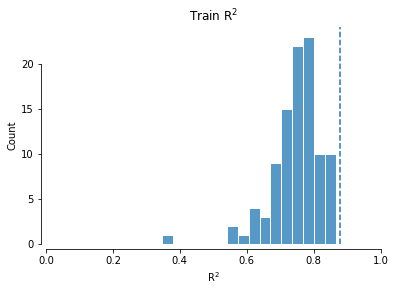

Phi Average 0.12957347834666966
Phi Better 0


In [16]:
sns.histplot(x=meas_r2, edgecolor='white', color='tab:blue', multiple='stack')
plt.axvline(original_r2_train,0,20, linestyle='--')
plt.xlim(0,1)
sns.despine(offset=5, trim=True)
plt.xlabel('R$^2$')
plt.legend('', frameon=False)
plt.title('Train R$^2$')
plt.show()

print('Phi Average ' + str(original_r2_train- np.mean(meas_r2)))
print('Phi Better ' + str(np.count_nonzero(original_r2_train<meas_r2)))


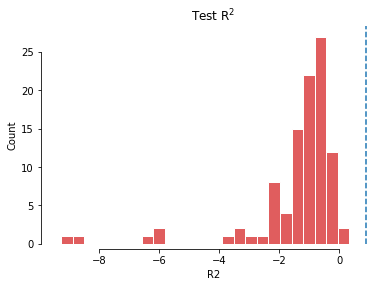

Phi Average 0.12957347834666966
Phi Better 0


In [17]:
sns.histplot(x=test_r2, edgecolor='white', color='tab:red', multiple='stack')
plt.axvline(original_r2_train,0,20, linestyle='--')
#plt.xlim(0,1)
sns.despine(offset=5, trim=True)
plt.xlabel('R2')
plt.legend('', frameon=False)
plt.title('Test R$^2$')
plt.show()

print('Phi Average ' + str(original_r2_train- np.mean(meas_r2)))
print('Phi Better ' + str(np.count_nonzero(original_r2_train<meas_r2)))

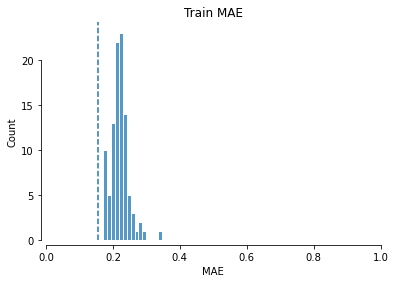

Phi average -0.06343467973699243
Phi Better 0


In [18]:
sns.histplot(x=meas_mae, edgecolor='white', color='tab:blue', multiple='stack')
plt.axvline(original_mae_train,0,20, linestyle='--')
plt.xlim(0,1)
sns.despine(offset=5, trim=True)
plt.xlabel('MAE')
plt.legend('', frameon=False)
plt.title('Train MAE')
plt.show()

print('Phi average ' + str(original_mae_train- np.mean(meas_mae)))
print('Phi Better ' + str(np.count_nonzero(original_mae_train>meas_mae)))


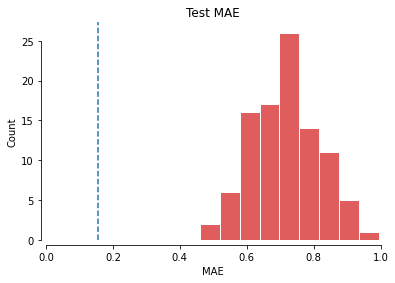

Phi average -0.06343467973699243
Phi Better 0


In [19]:
sns.histplot(x=test_mae, edgecolor='white', color='tab:red', multiple='stack')
plt.axvline(original_mae_train,0,20, linestyle='--')
plt.xlim(0,1)
sns.despine(offset=5, trim=True)
plt.xlabel('MAE')
plt.legend('', frameon=False)
plt.title('Test MAE')
plt.show()

print('Phi average ' + str(original_mae_train- np.mean(meas_mae)))
print('Phi Better ' + str(np.count_nonzero(original_mae_train>meas_mae)))